In [123]:
# # Google Colab specific
# %cd ~/../content
# !rm -rf openet

# !git clone https://github.com/aetriusgx/openet.git
# %cd openet

# Data Preparation

In [124]:
from matplotlib.colors import LinearSegmentedColormap
from datetime import datetime, timedelta
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import geopandas as gpd
import json
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

In [125]:
# Styling Cell
sns.set_theme(context="notebook", style="whitegrid")

SMALL_SIZE = 18
MEDIUM_SIZE = 24
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Historical Data Import

In [126]:
historical = pd.read_csv('./data/kern_historical.csv', low_memory=False)
historical['time'] = pd.to_datetime(historical['time'])
historical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3406782 entries, 0 to 3406781
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   field_id     object        
 1   crop         int64         
 2   time         datetime64[ns]
 3   actual_et    float64       
 4   actual_eto   float64       
 5   actual_etof  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 156.0+ MB


## Forecast Table Build

In [127]:
# Gather current forecast data for the county
forecasting_table = pd.DataFrame()
files = Path(f"data/forecasts/kern/").glob("*.csv")

for file in files:
    # splits into [$date, 'forecast.csv']
    parts = str(file.name).split("_")
    data = pd.read_csv(file, low_memory=False)
    data["forecasting_date"] = parts[0]
    forecasting_table = pd.concat([data, forecasting_table], ignore_index=True)

forecasting_table['forecasting_date'] = pd.to_datetime(forecasting_table['forecasting_date'])
forecasting_table['time'] = pd.to_datetime(forecasting_table['time'])
forecasting_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12321756 entries, 0 to 12321755
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   field_id          object        
 1   crop              int64         
 2   time              datetime64[ns]
 3   expected_et       float64       
 4   expected_eto      float64       
 5   expected_etof     float64       
 6   forecasting_date  datetime64[ns]
dtypes: datetime64[ns](2), float64(3), int64(1), object(1)
memory usage: 658.1+ MB


## Main Data Table compilation

In [128]:
dt = historical.loc[(historical['time'].dt.year == 2024), :]
dt = dt.merge(forecasting_table, on=['field_id', 'time', 'crop'], how='right').set_index(['forecasting_date', 'field_id', 'crop', 'time']).reset_index()
dt = dt[(dt['time'].dt.month < 8)]
dt

forecasting_date   field_id  crop       time  actual_et  actual_eto  \
0              2024-07-29   CA_27267    61 2024-01-01      0.043       0.951   
1              2024-07-29   CA_27267    61 2024-01-02      0.030       0.740   
2              2024-07-29   CA_27267    61 2024-01-03      0.062       1.691   
3              2024-07-29   CA_27267    61 2024-01-04      0.062       1.902   
4              2024-07-29   CA_27267    61 2024-01-05      0.039       1.374   
...                   ...        ...   ...        ...        ...         ...   
12321598       2024-01-01  CA_423678    61 2024-07-27      0.844       7.681   
12321599       2024-01-01  CA_423678    61 2024-07-28      0.808       7.351   
12321600       2024-01-01  CA_423678    61 2024-07-29      0.771       7.020   
12321601       2024-01-01  CA_423678    61 2024-07-30      0.790       7.185   
12321602       2024-01-01  CA_423678    61 2024-07-31      0.699       6.360   

          actual_etof  expected_et  expected_eto  expected_etof  
0               0.045        0.043         0.951          0.045  
1               0.041        0.030         0.740          0.041  
2               0.037        0.062         1.691          0.037  
3               0.032        0.062         1.902          0.032  
4               0.028        0.039         1.374          0.028  
...               ...          ...           ...            ...  
12321598        0.110        5.537         8.238          0.562  
12321599        0.110        5.776         7.805          0.567  
12321600        0.110        5.933         7.443          0.572  
12321601        0.110        6.009         7.412          0.578  
12321602        0.110        6.012         7.349          0.585  

[7170858 rows x 10 columns]

### Add geographical data

In [129]:
# Add additional data to the data table
kern_points = pd.read_csv("./data/Kern.csv", low_memory=False).set_index("OPENET_ID").rename_axis("field_id")

# Expand .geo column into lon, lat columns
kern_geo = (kern_points[".geo"]
                .apply(lambda x: pd.Series(dict(json.loads(x))))['coordinates']
                .apply(lambda x: pd.Series(list(x), index=['longitude', 'latitude'])))
kern_geo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1086 entries, CA_33179 to CA_39812
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   longitude  1086 non-null   float64
 1   latitude   1086 non-null   float64
dtypes: float64(2)
memory usage: 25.5+ KB


### Add USDA crop data

In [130]:
# Add crop data
cdl_codes = pd.read_csv("./data/cdl_codes.csv", low_memory=False).set_index("Codes")

dt = dt.join(cdl_codes, how="left", on="crop", validate="many_to_many")
dt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7170858 entries, 0 to 12321602
Data columns (total 17 columns):
 #   Column            Dtype         
---  ------            -----         
 0   forecasting_date  datetime64[ns]
 1   field_id          object        
 2   crop              int64         
 3   time              datetime64[ns]
 4   actual_et         float64       
 5   actual_eto        float64       
 6   actual_etof       float64       
 7   expected_et       float64       
 8   expected_eto      float64       
 9   expected_etof     float64       
 10  Class_Names       object        
 11  ESRI_Red          int64         
 12  ESRI_Green        int64         
 13  ESRI_Blue         int64         
 14  Erdas_Red         float64       
 15  Erdas_Green       float64       
 16  Erdas_Blue        float64       
dtypes: datetime64[ns](2), float64(9), int64(4), object(2)
memory usage: 984.8+ MB


### Add Field Metadata

In [131]:
# Import table using only field and hectare columns
field_metadata = pd.read_json('./data/geo/kern_metadata.json')[['field_id', 'hectares']]
# Reformat field IDs to be same convention as the other tables.
field_metadata['field_id'] = 'CA_' + field_metadata['field_id'].astype(str).str[1:]
field_metadata = field_metadata.set_index('field_id')
field_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1085 entries, CA_27267 to CA_42345
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   hectares  1085 non-null   float64
dtypes: float64(1)
memory usage: 17.0+ KB


In [132]:
dt = dt.join(field_metadata, how='left', on='field_id', validate='many_to_one')
dt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7170858 entries, 0 to 12321602
Data columns (total 18 columns):
 #   Column            Dtype         
---  ------            -----         
 0   forecasting_date  datetime64[ns]
 1   field_id          object        
 2   crop              int64         
 3   time              datetime64[ns]
 4   actual_et         float64       
 5   actual_eto        float64       
 6   actual_etof       float64       
 7   expected_et       float64       
 8   expected_eto      float64       
 9   expected_etof     float64       
 10  Class_Names       object        
 11  ESRI_Red          int64         
 12  ESRI_Green        int64         
 13  ESRI_Blue         int64         
 14  Erdas_Red         float64       
 15  Erdas_Green       float64       
 16  Erdas_Blue        float64       
 17  hectares          float64       
dtypes: datetime64[ns](2), float64(10), int64(4), object(2)
memory usage: 1.0+ GB


### List of identifiers

In [133]:
forecast_dates = forecasting_table['forecasting_date'].unique()
fields = dt['field_id'].unique()
crops = dt['crop'].unique()

# Analysis

## Helpers
Below are functions that are being used to calculate data and generate plots.

The tables below are also calculated prior to speed up metric calculations.

### Average ET/ETo/ETof for 2024
This table will be used as a reference for any metric and plot calculations

In [134]:
avgs_table = dt.groupby(['field_id', 'crop'])[['actual_et', 'actual_eto', 'actual_etof']].agg('mean')
avgs_table.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1086 entries, ('CA_27267', 61) to ('CA_423678', 61)
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   actual_et    1086 non-null   float64
 1   actual_eto   1086 non-null   float64
 2   actual_etof  1086 non-null   float64
dtypes: float64(3)
memory usage: 37.4+ KB


### Climatology Reference
The table below records the average conditions for each field for each day of the year.

In [135]:
# Create a column for day of year
historical['doy'] = historical['time'].dt.dayofyear
# Group by field, crop, and doy then calculate the average conditions
climatology_table = historical.groupby(['field_id', 'crop', 'doy'])[['actual_et', 'actual_eto', 'actual_etof']].agg('mean')
climatology_table.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 397476 entries, ('CA_27267', 61, 1) to ('CA_423678', 61, 366)
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   actual_et    397476 non-null  float64
 1   actual_eto   397476 non-null  float64
 2   actual_etof  397476 non-null  float64
dtypes: float64(3)
memory usage: 11.0+ MB


### calculate_metrics
This function calculate the mean absolute error (mae), root mean squared error (rmse), mean forecast error (bias), correlation coefficient (R), and skill score.

MAE, RMSE, and R are calculated using sklearn's metric module.

Skill score is calculated by getting the climatology for each field within the input's date range.
* Negative skill scores indicate the MSE for forecast is larger than the MSE for climatology
* Positive skill scores indicate otherwise

The function is very flexible given the data is formatted appropriately. It has the option of enabling normalization which is based on the average specified variable (ET, ETo, or ETof) throughout that field's historical data.

In [136]:
def calculate_metrics(data: pd.DataFrame, *, 
                      historical: pd.DataFrame, 
                      climatology_ref: pd.DataFrame = climatology_table,
                      avgs_ref: pd.DataFrame = avgs_table,
                      actual: str, expected: str, 
                      normalize: bool = False) -> pd.Series:
	# Calculate error metrics
    mae: float = mean_absolute_error(data[actual], data[expected])
    forecast_mse: float = mean_squared_error(data[actual], data[expected])
    rmse: float = np.sqrt(forecast_mse)

    # Correlation Coefficient (R)
    cor = data[actual].corr(data[expected]).astype(float)
    
    # Mean Forecast Bias determines if the forecast is overshooting or undershooting.
    # Greater positive number indicates overshooting.
    bias: float = np.mean(data[expected] - data[actual])

	# Climatology uses the mean actual variable for that time of year using historical data.
    field = data.head(1).squeeze()
    start_date = data['time'].min().dayofyear
    end_date = data['time'].max().dayofyear

	# Filter the climatology reference
    field_mask = (climatology_ref.index.get_level_values(0) == field['field_id'])
    crop_mask = (climatology_ref.index.get_level_values(1) == field['crop'])
    date_mask = ((climatology_ref.index.get_level_values(2) >= start_date) & (climatology_ref.index.get_level_values(2) <= end_date))
    
    climatology = climatology_ref[field_mask & crop_mask & date_mask][actual]
    climatology_mse = mean_squared_error(data[actual], climatology)

	# Positive skill score indicates the error in climatology is greater than forecast.
    # This means that forecast is outperforming climatology.
    skill_score = 1 - np.max(np.min((forecast_mse / climatology_mse), initial=2), initial=-1)

    if normalize:
    	avg: float = avgs_ref[avgs_ref.index.get_level_values(0) == field['field_id']][actual].values[0]

    	mae: float = mae.astype(float) / avg.astype(float)
    	rmse = np.sqrt(forecast_mse.astype(float) / avg.astype(float))
    	bias = bias.astype(float) / avg.astype(float)

    return pd.Series({
    	'mae': mae.round(2),
    	'rmse': rmse.round(2),
    	'corr': cor.round(2),
    	'bias': bias.round(2),
    	'skill_score': skill_score.round(2)
	})

### eval_metrics
This function evaluates the metrics for each variable. The output is a DataFrame containing the metrics with a column specifying which variable (ET, ETo, ETof)

In [137]:
def eval_metrics(table: pd.DataFrame, by=['field_id', 'crop'], **kwargs) -> pd.DataFrame:
    metrics_table = pd.DataFrame(columns=["field_id", "variable", "crop", "mae", "rmse", "corr", "bias", "skill_score"])

    et_metrics = table.groupby(by=by)[["field_id", "crop", "time", "actual_et", "expected_et"]].apply(calculate_metrics, historical=historical,
                                                                      actual='actual_et', expected='expected_et', **kwargs).reset_index()
    et_metrics['variable'] = "ET"

    metrics_table = pd.concat([et_metrics.astype(metrics_table.dtypes), metrics_table.astype(et_metrics.dtypes)], ignore_index=True)

    eto_metrics = table.groupby(by=by)[["field_id", "crop", "time", "actual_eto", "expected_eto"]].apply(calculate_metrics, historical=historical,
                                                                      actual='actual_eto', expected='expected_eto', **kwargs).reset_index()
    eto_metrics['variable'] = "ETo"
    metrics_table = pd.concat([eto_metrics.astype(metrics_table.dtypes), metrics_table.astype(eto_metrics.dtypes)], ignore_index=True)

    etof_metrics = table.groupby(by=by)[["field_id", "crop", "time", "actual_etof", "expected_etof"]].apply(calculate_metrics, historical=historical,
                                                                      actual='actual_etof', expected='expected_etof', **kwargs).reset_index()
    etof_metrics['variable'] = "ETof"
    metrics_table = pd.concat([etof_metrics.astype(metrics_table.dtypes), metrics_table.astype(etof_metrics.dtypes)], ignore_index=True)

    return metrics_table

### timeseries_rel
This plot function utilizes the seaborn relplot method to create grids of plots. Particularly useful for showing distribution on one cell.

In [138]:
def timeseries_rel(data, *, y, plot='rel',
                   col=None, row=None, hue=None, kind='line', 
                   title='', ylabel='', as_percent=False, tighten=False, refline=None,
                   errorbar=None, export_img: bool|str=None, title_template={}, **kwargs):
    match plot:
        case 'rel':
            rel = sns.relplot(data=data, x='forecasting_date', y=y, col=col, row=row, hue=hue, kind=kind, errorbar=errorbar, **kwargs)
        case 'dis': 
            rel = sns.displot(data=data, x=y, col=col, row=row, hue=hue, kind=kind, **kwargs)
        case 'cat':
            rel = sns.catplot(data=data, x='forecasting_date', y=y, col=col, row=row, hue=hue, kind=kind, errorbar=errorbar, **kwargs)
        case 'lm':
            rel = sns.lmplot(data=data, x='forecasting_date', y=y, col=col, row=row, hue=hue, kind=kind, errorbar=errorbar, **kwargs)
        case _:
            raise Exception('Not a valid plot type.')

    # Relabel y axis
    if ylabel: rel.set_ylabels(ylabel)
    # Relabel x axis
    rel.tick_params(axis='x', rotation=90)
    plt.suptitle(title, y=1.02);
    rel.set_titles(**title_template);

    if as_percent is True:
        for ax in rel.axes.flat:
            ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    if plot != 'dis':
        rel.set_xlabels('Forecasting Date')
        for ax in rel.axes.flat:
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%B'))

    if tighten:
        rel.figure.subplots_adjust(wspace=0, hspace=0.1)

    if refline:
        rel.refline(**refline)

    if type(export_img) is bool and export_img is True: 
        rel.savefig(fname=f'images/kern/{str(title)}')
    elif type(export_img) is str: 
        rel.savefig(fname=f'images/kern/{export_img}')

    return rel

### trim_extremes
Trim the edges of the DataFrame along provided columns with provided threshold.

In [139]:
def trim_extremes(data, *, cols, threshold):
    # Convert single input as list
    if type(cols) is not list:
        cols = [cols]
    # Go through each column. Rank the values by % then remove the extremes.
    for c in cols:
        data[f'{c}_pct'] = data[c].rank(pct=True)
        data.drop(index=data[(data[f'{c}_pct'] <= threshold)].index, inplace=True)
        data.drop(columns=f'{c}_pct', inplace=True)
    return data

## Calculation

In [140]:
analysis_end_date = historical['time'].max()

Est. run time: 21m

In [141]:
# metrics_norm = (dt[(dt['time'] > dt['forecasting_date']) & (dt['time'] < (dt['forecasting_date']) + timedelta(days=7))]
#                 .groupby(['forecasting_date'])[list(dt.columns)]
#                 .apply(eval_metrics, normalize=True))
# metrics_norm.reset_index().to_csv('data/metrics/kern_metrics_normalized.csv', index=False)

In [142]:
metrics_norm = pd.read_csv('data/metrics/kern_metrics_normalized.csv').drop(['level_1'], axis=1)
metrics_norm['forecasting_date'] = pd.to_datetime(metrics_norm['forecasting_date'])

In [143]:
# metrics_norm = (metrics_norm.groupby(['forecasting_date', 'variable'])[['field_id', 'crop', 'mae', 'rmse', 'bias', 'corr', 'skill_score']]
#                 .apply(trim_extremes, cols=['mae', 'rmse', 'bias', 'corr', 'skill_score'], threshold=0.05))
# metrics_norm.info()

### Crop metrics

In [144]:
# crop_metrics = (dt[(dt['time'] > dt['forecasting_date']) & (dt['time'] < (dt['forecasting_date']) + timedelta(days=7))]
#                 .groupby(by=['forecasting_date', 'crop'])[list(dt.columns)]
#                 .apply(eval_metrics, normalize=True))
# crop_metrics.to_csv('data/metrics/kern_crop_metrics.csv')

In [145]:
crop_metrics = pd.read_csv('data/metrics/kern_crop_metrics.csv', low_memory=False).drop(['Unnamed: 2', 'crop.1'], axis=1)
crop_metrics['forecasting_date'] = pd.to_datetime(crop_metrics['forecasting_date'])

In [146]:
crop_metrics = (crop_metrics.groupby(['forecasting_date', 'variable'])[['field_id', 'crop', 'mae', 'rmse', 'bias', 'corr', 'skill_score']]
                    .apply(trim_extremes, cols=['mae', 'rmse', 'bias', 'corr', 'skill_score'], threshold=0.05))
                    
crop_metrics.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 82802 entries, (Timestamp('2024-01-01 00:00:00'), 'ET', 2) to (Timestamp('2024-07-29 00:00:00'), 'ETof', 100910)
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   field_id     82802 non-null  object 
 1   crop         82802 non-null  int64  
 2   mae          82802 non-null  float64
 3   rmse         82802 non-null  float64
 4   bias         82802 non-null  float64
 5   corr         81050 non-null  float64
 6   skill_score  82802 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 7.5+ MB


# Visualization

## Metric Correlation

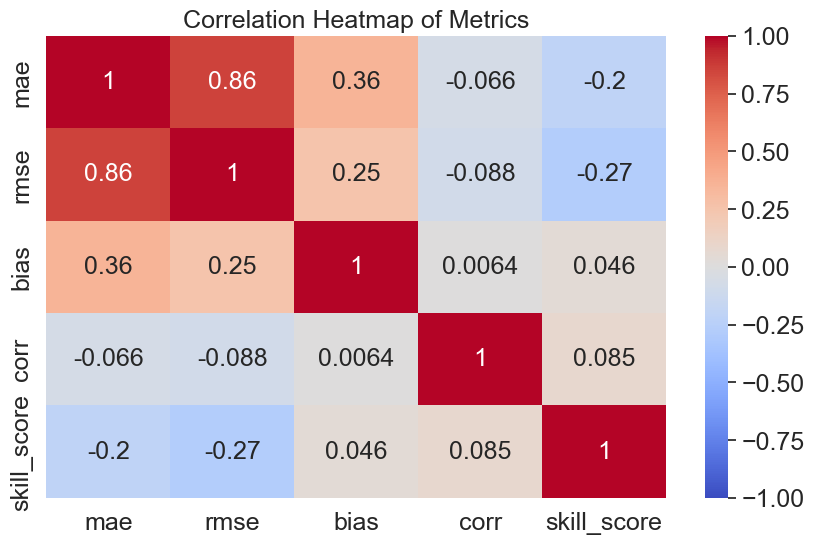

In [147]:
plt.figure(figsize=(10, 6))
metrics = ['mae', 'rmse', 'bias', 'corr', 'skill_score']
corr_matrix = metrics_norm[metrics].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Metrics')
plt.savefig('images/kern/field_metric_correlation.png')

## Distribution of Metrics

In [148]:
# First reshape data from wide-form to long-form
metrics_long = metrics_norm.reset_index().melt(id_vars=['forecasting_date', 'field_id', 'crop', 'variable'], value_vars=['mae', 'bias', 'skill_score'], var_name='stat')

In [149]:
# To help with visualization, map proper names to the stats
stat_propers = {
    'mae': 'Mean Absolute Error',
    'rmse': 'Root Mean Absolute Error',
    'bias': 'Mean Forecast Bias',
    'corr': 'Correlation Coefficient',
    'skill_score': 'Skill Score'
}
metrics_long['name'] = metrics_long['stat'].map(stat_propers)
metrics_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302994 entries, 0 to 302993
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   forecasting_date  302994 non-null  datetime64[ns]
 1   field_id          302994 non-null  object        
 2   crop              302994 non-null  int64         
 3   variable          302994 non-null  object        
 4   stat              302994 non-null  object        
 5   value             302994 non-null  float64       
 6   name              302994 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 16.2+ MB


### Boxplot Distribution

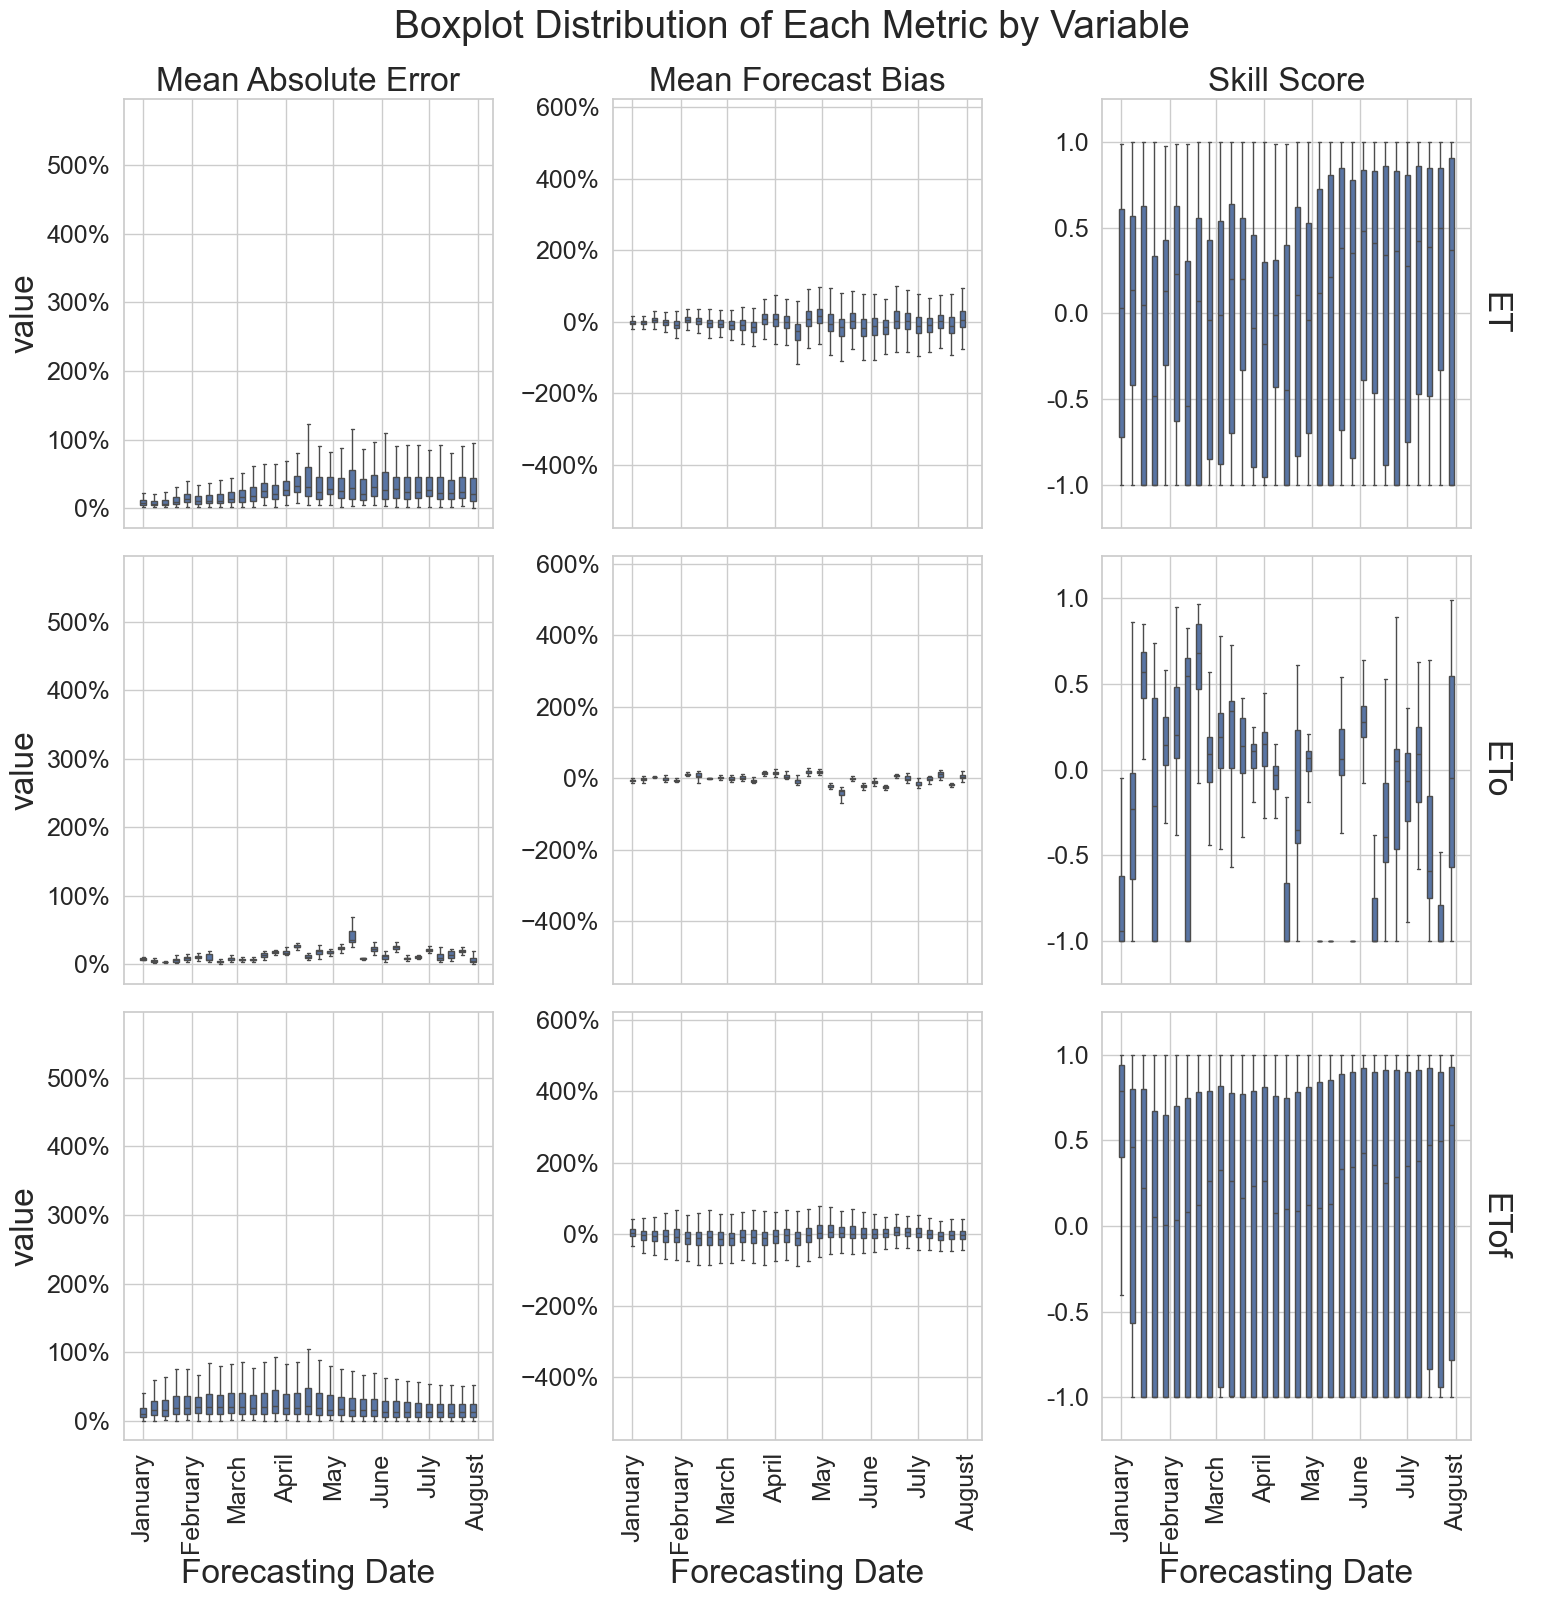

In [150]:
rel = timeseries_rel(data=metrics_long, plot='cat', kind='box',
                y='value', col='name', row='variable',
                width=0.5, errorbar='sd',
                flierprops=dict(markersize=0), title="Boxplot Distribution of Each Metric by Variable",
                export_img='field_boxplots.png', as_percent=True, margin_titles=True,
                row_order=['ET', 'ETo', 'ETof'], title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                facet_kws={"despine": False}, sharey='col', native_scale=True
               );
rel.axes.flat[2].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[2].set(ylim=(-1.25, 1.25));
rel.axes.flat[2].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig('images/kern/field_boxplots.png')

### Metric Distrbution by Standard Deviation

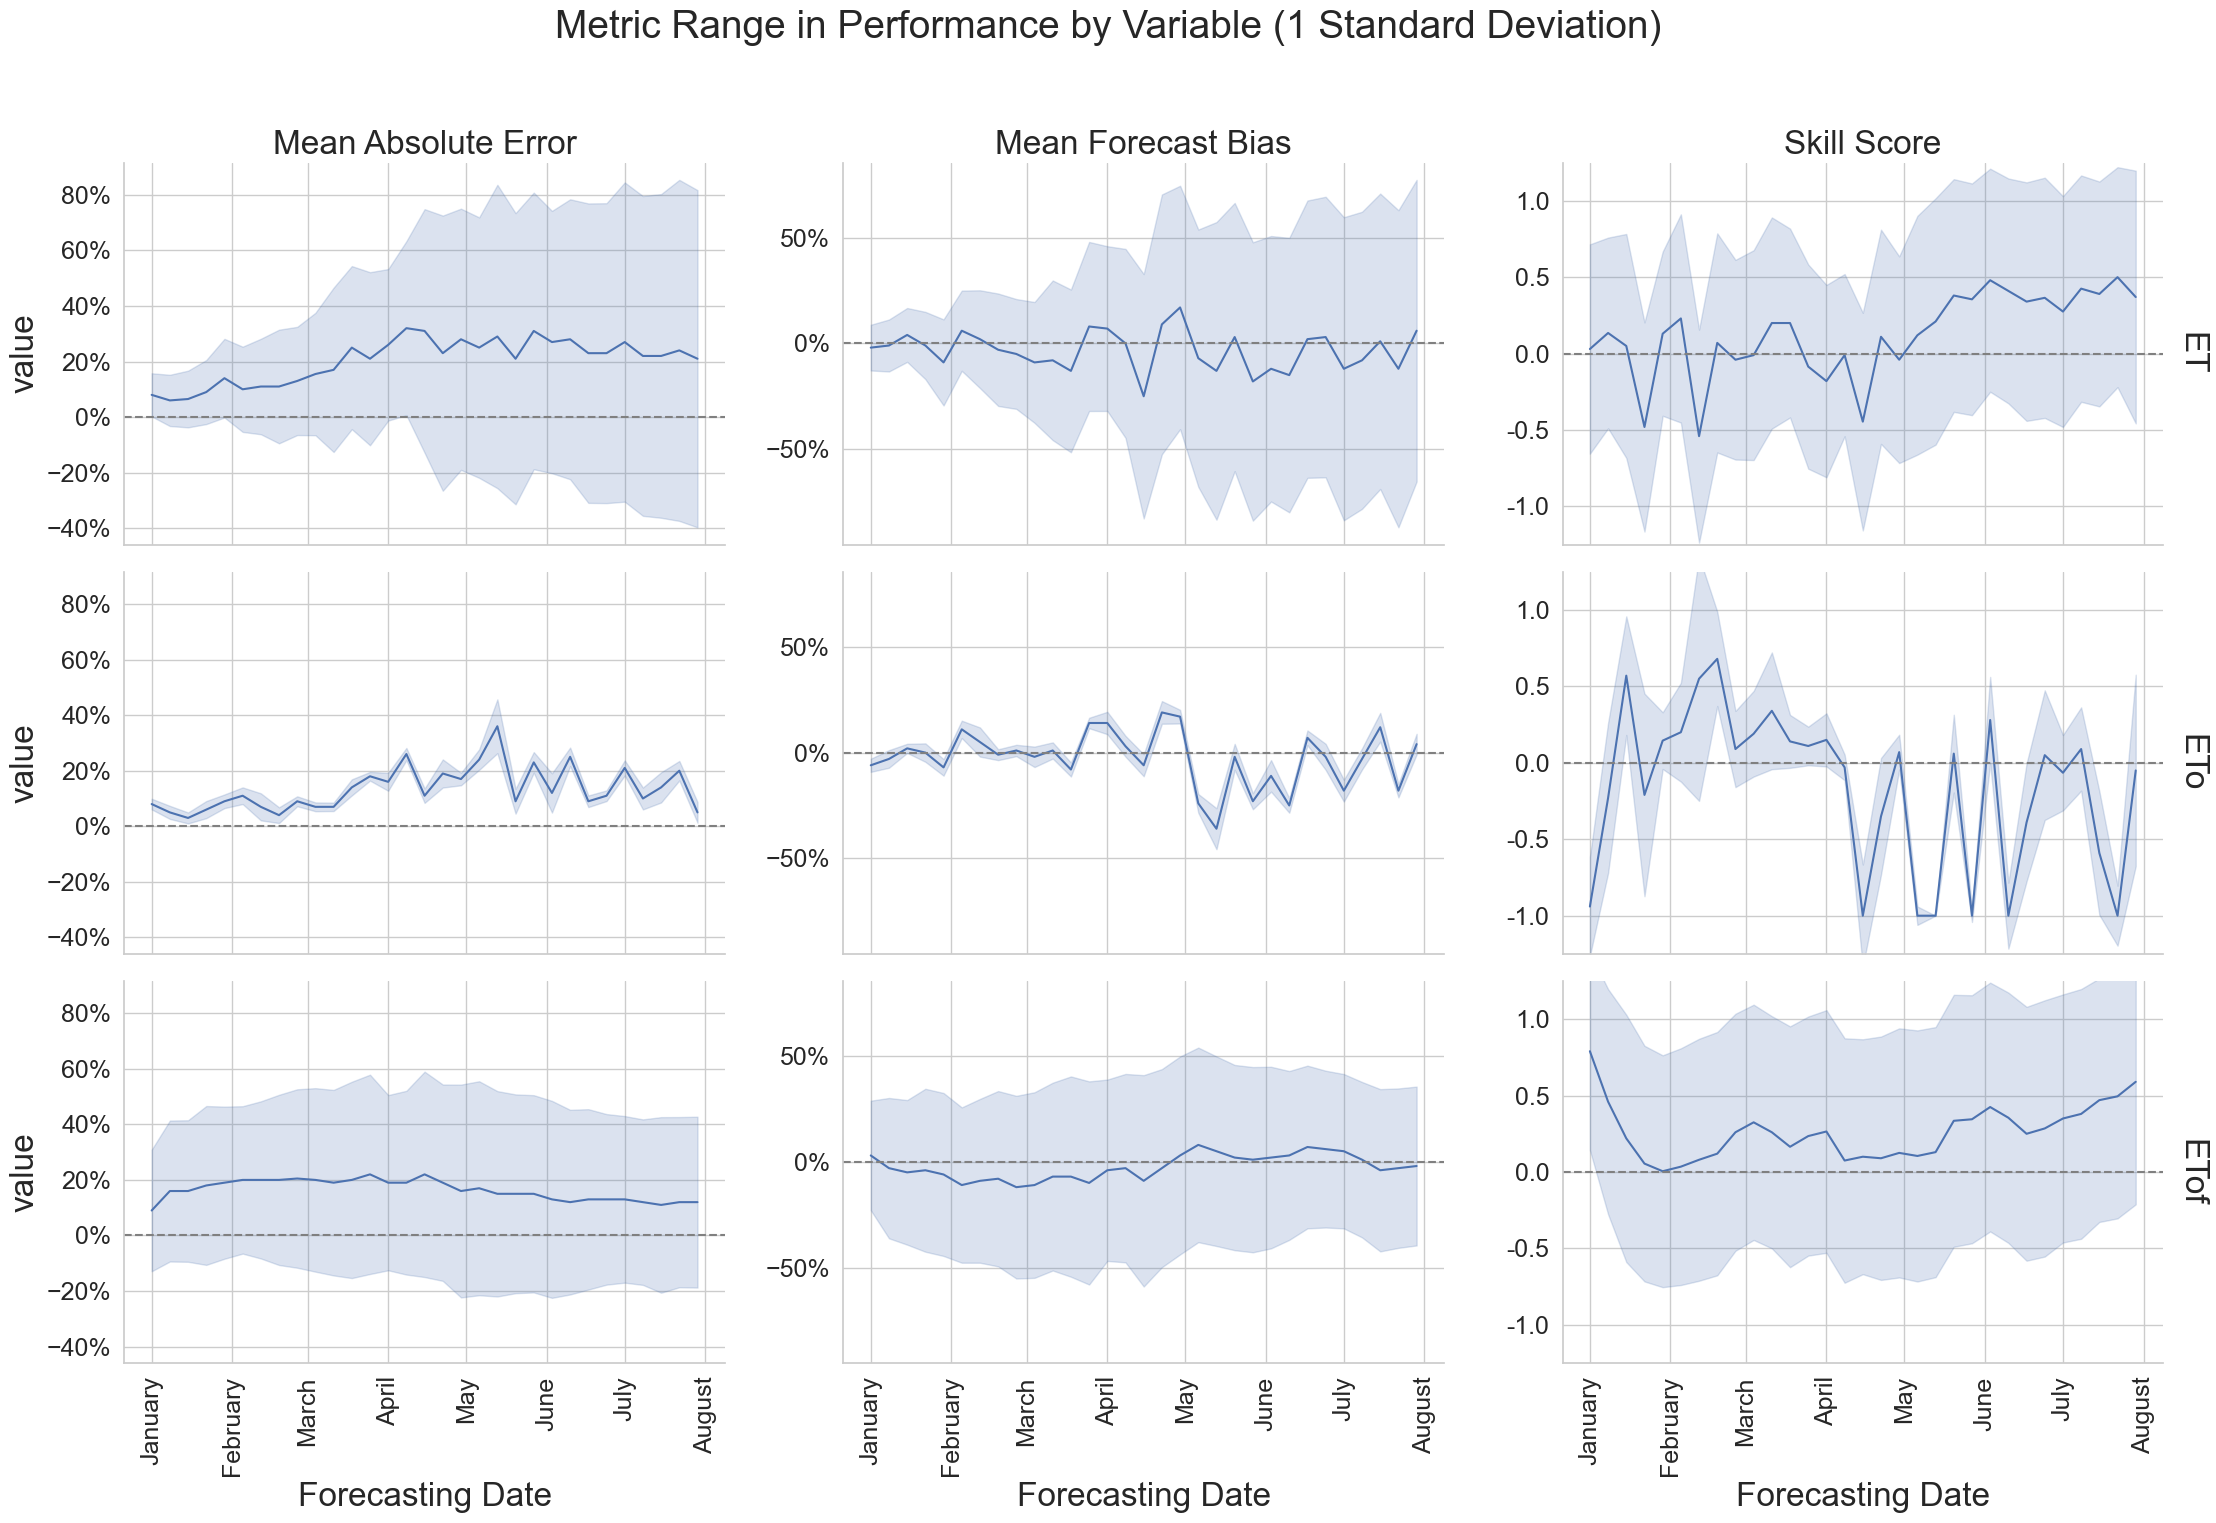

In [151]:
rel = timeseries_rel(metrics_long, row='variable', col='name', y='value',
                     errorbar='sd', estimator=np.median, as_percent=True, aspect=1.5,
                     refline={'y': 0},
                     facet_kws={'sharey': 'col', 'sharex': True, 'margin_titles': True},
                     row_order=['ET', 'ETo', 'ETof'], title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                     title="Metric Range in Performance by Variable (1 Standard Deviation)");
rel.axes.flat[2].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[2].set(ylim=(-1.25, 1.25));
rel.axes.flat[2].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig('images/kern/field_metric_range_sd.png')

## Crop Metrics

In [152]:
# Reappend class names of crops for better readability in plots.
metrics_long = metrics_long.join(cdl_codes, how="left", on="crop", validate="many_to_many")

In [153]:
# crop_selector = dt.groupby('crop')['hectares'].agg('sum')[:3]
crop_selector = [69, 72, 75]

In [154]:
dt[dt['crop'].isin(crop_selector)].groupby('crop')['field_id'].nunique()

crop
69    181
72    130
75    228
Name: field_id, dtype: int64

In [155]:
crop_plotter = metrics_long[metrics_long['crop'].isin(crop_selector)]
crop_plotter.head()

forecasting_date   field_id  crop variable stat  value  \
1        2024-01-01  CA_297922    75     ETof  mae   0.09   
8        2024-01-01  CA_298100    69     ETof  mae   0.41   
9        2024-01-01  CA_298141    72     ETof  mae   0.16   
10       2024-01-01  CA_298142    72     ETof  mae   0.32   
11       2024-01-01  CA_298159    72     ETof  mae   0.06   

                   name Class_Names  ESRI_Red  ESRI_Green  ESRI_Blue  \
1   Mean Absolute Error     Almonds         0         168        132   
8   Mean Absolute Error      Grapes       112          68        137   
9   Mean Absolute Error      Citrus       255         255        128   
10  Mean Absolute Error      Citrus       255         255        128   
11  Mean Absolute Error      Citrus       255         255        128   

    Erdas_Red  Erdas_Green  Erdas_Blue  
1      0.0000       0.6471      0.5098  
8      0.4392       0.2667      0.5373  
9      1.0000       1.0000      0.4980  
10     1.0000       1.0000      0.4980  
11     1.0000       1.0000      0.4980

### Probability Distributions

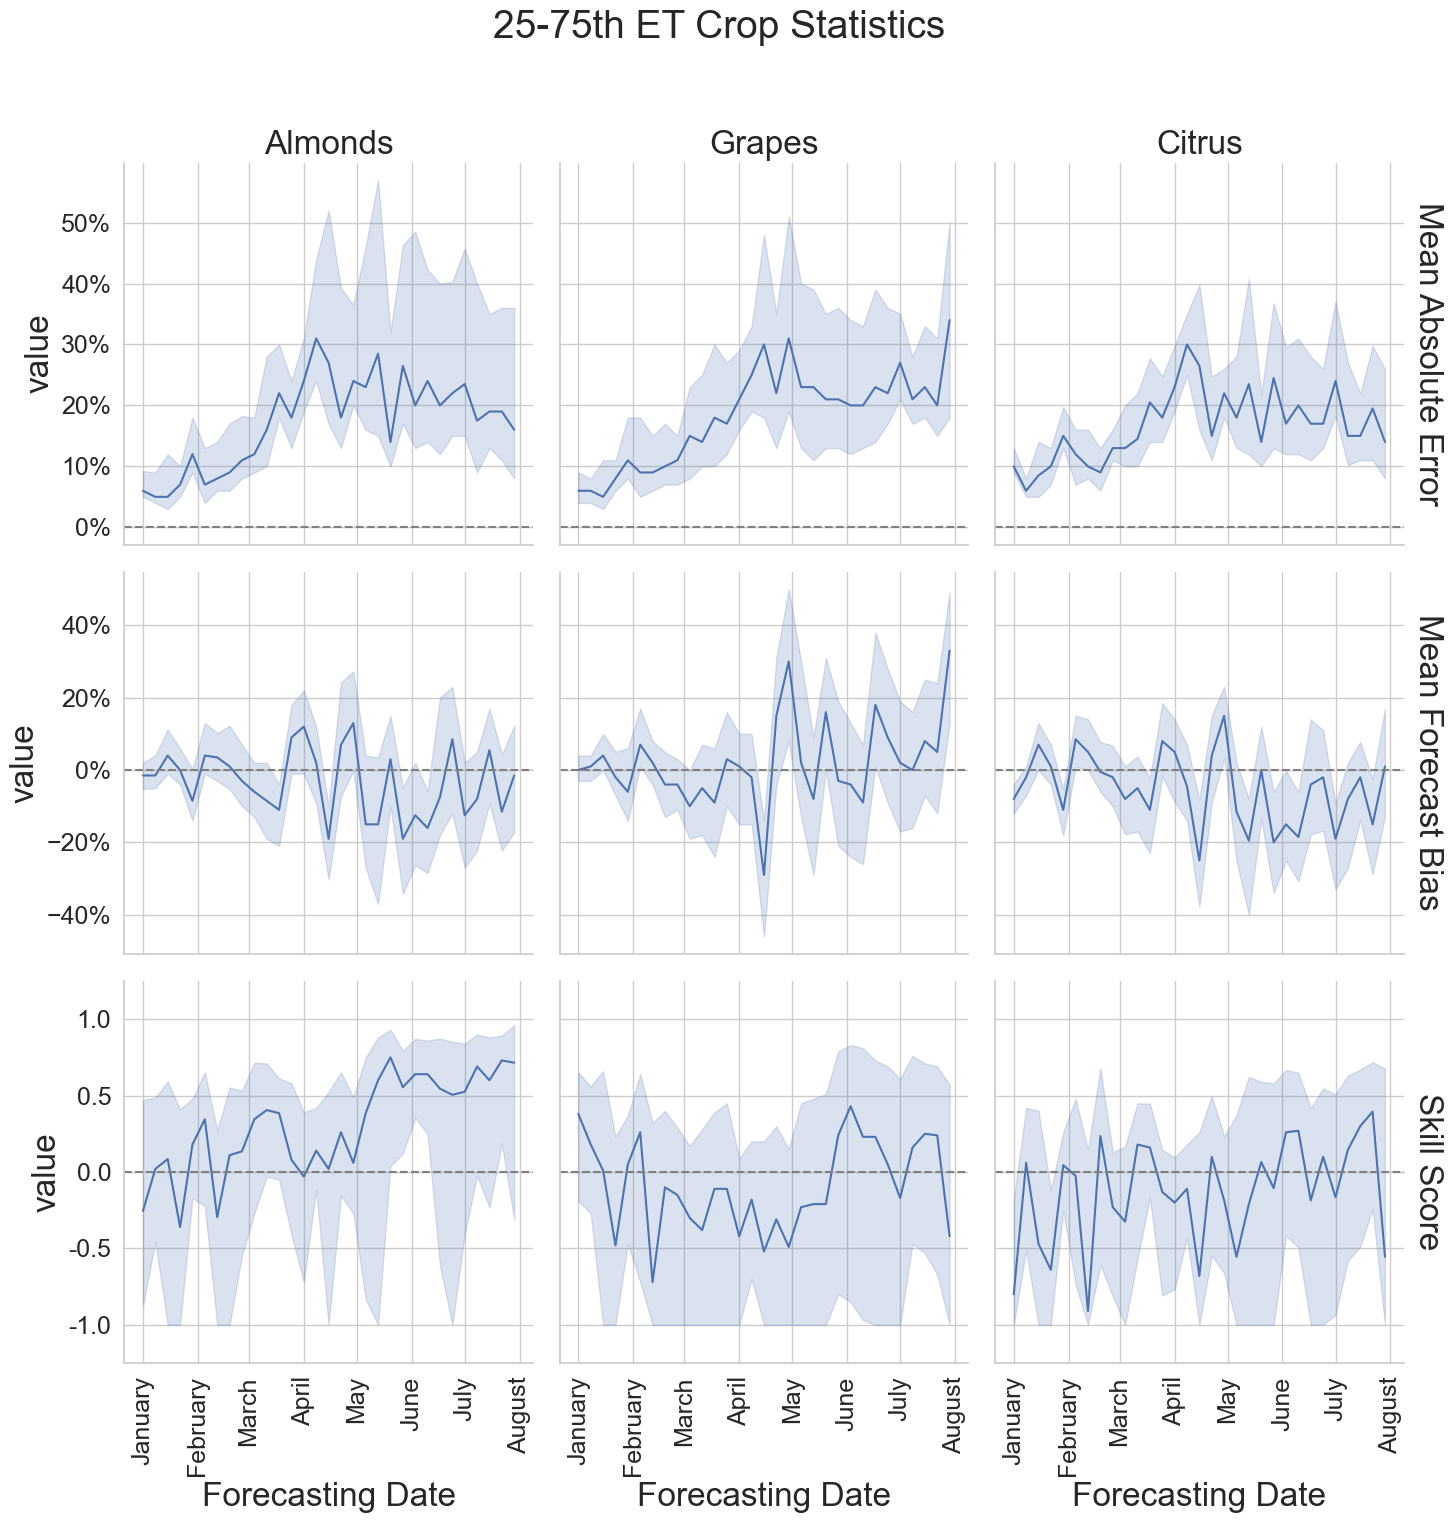

In [156]:
rel = timeseries_rel(crop_plotter[crop_plotter['variable'] == 'ET'], y='value', plot='rel', kind='line',
                col='Class_Names', row='name',
                refline={'y': 0},
                facet_kws={'sharey': 'row', 'sharex': True, 'margin_titles': True}, 
                estimator=np.median, errorbar=('pi', 50), title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                title='25-75th ET Crop Statistics', as_percent=True);
rel.axes.flat[7].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[7].set(ylim=(-1.25, 1.25));
rel.axes.flat[7].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig("images/kern/et_crop_stats.png")

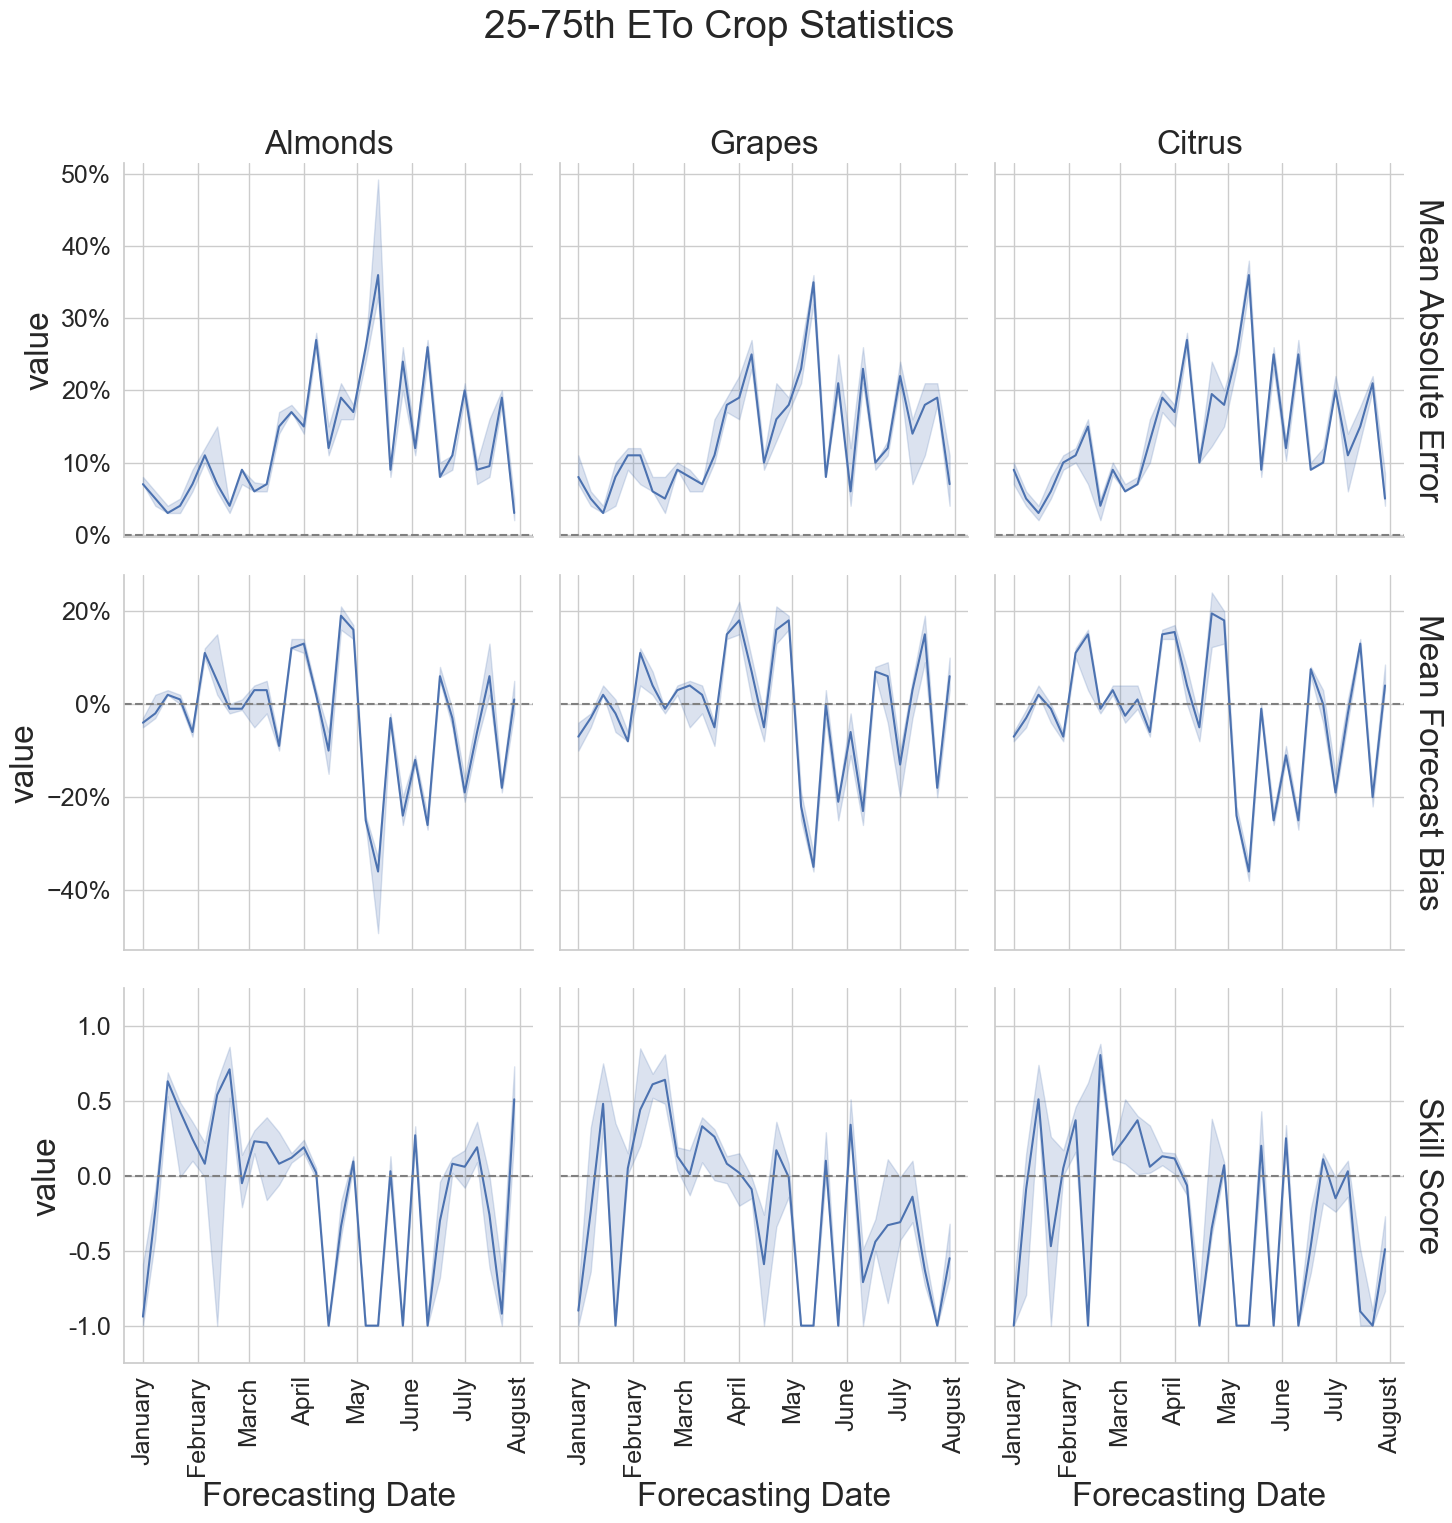

In [157]:
rel = timeseries_rel(crop_plotter[crop_plotter['variable'] == 'ETo'], y='value', plot='rel', kind='line', errorbar=('pi', 50),
                            col='Class_Names', row='name', facet_kws={'sharey': 'row', 'sharex': True, "margin_titles": True},
                            refline={'y': 0},
                            estimator=np.median, export_img="eto_crop_stats", title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                            title='25-75th ETo Crop Statistics', as_percent=True);
rel.axes.flat[7].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[7].set(ylim=(-1.25, 1.25));
rel.axes.flat[7].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig("images/kern/eto_crop_stats.png")

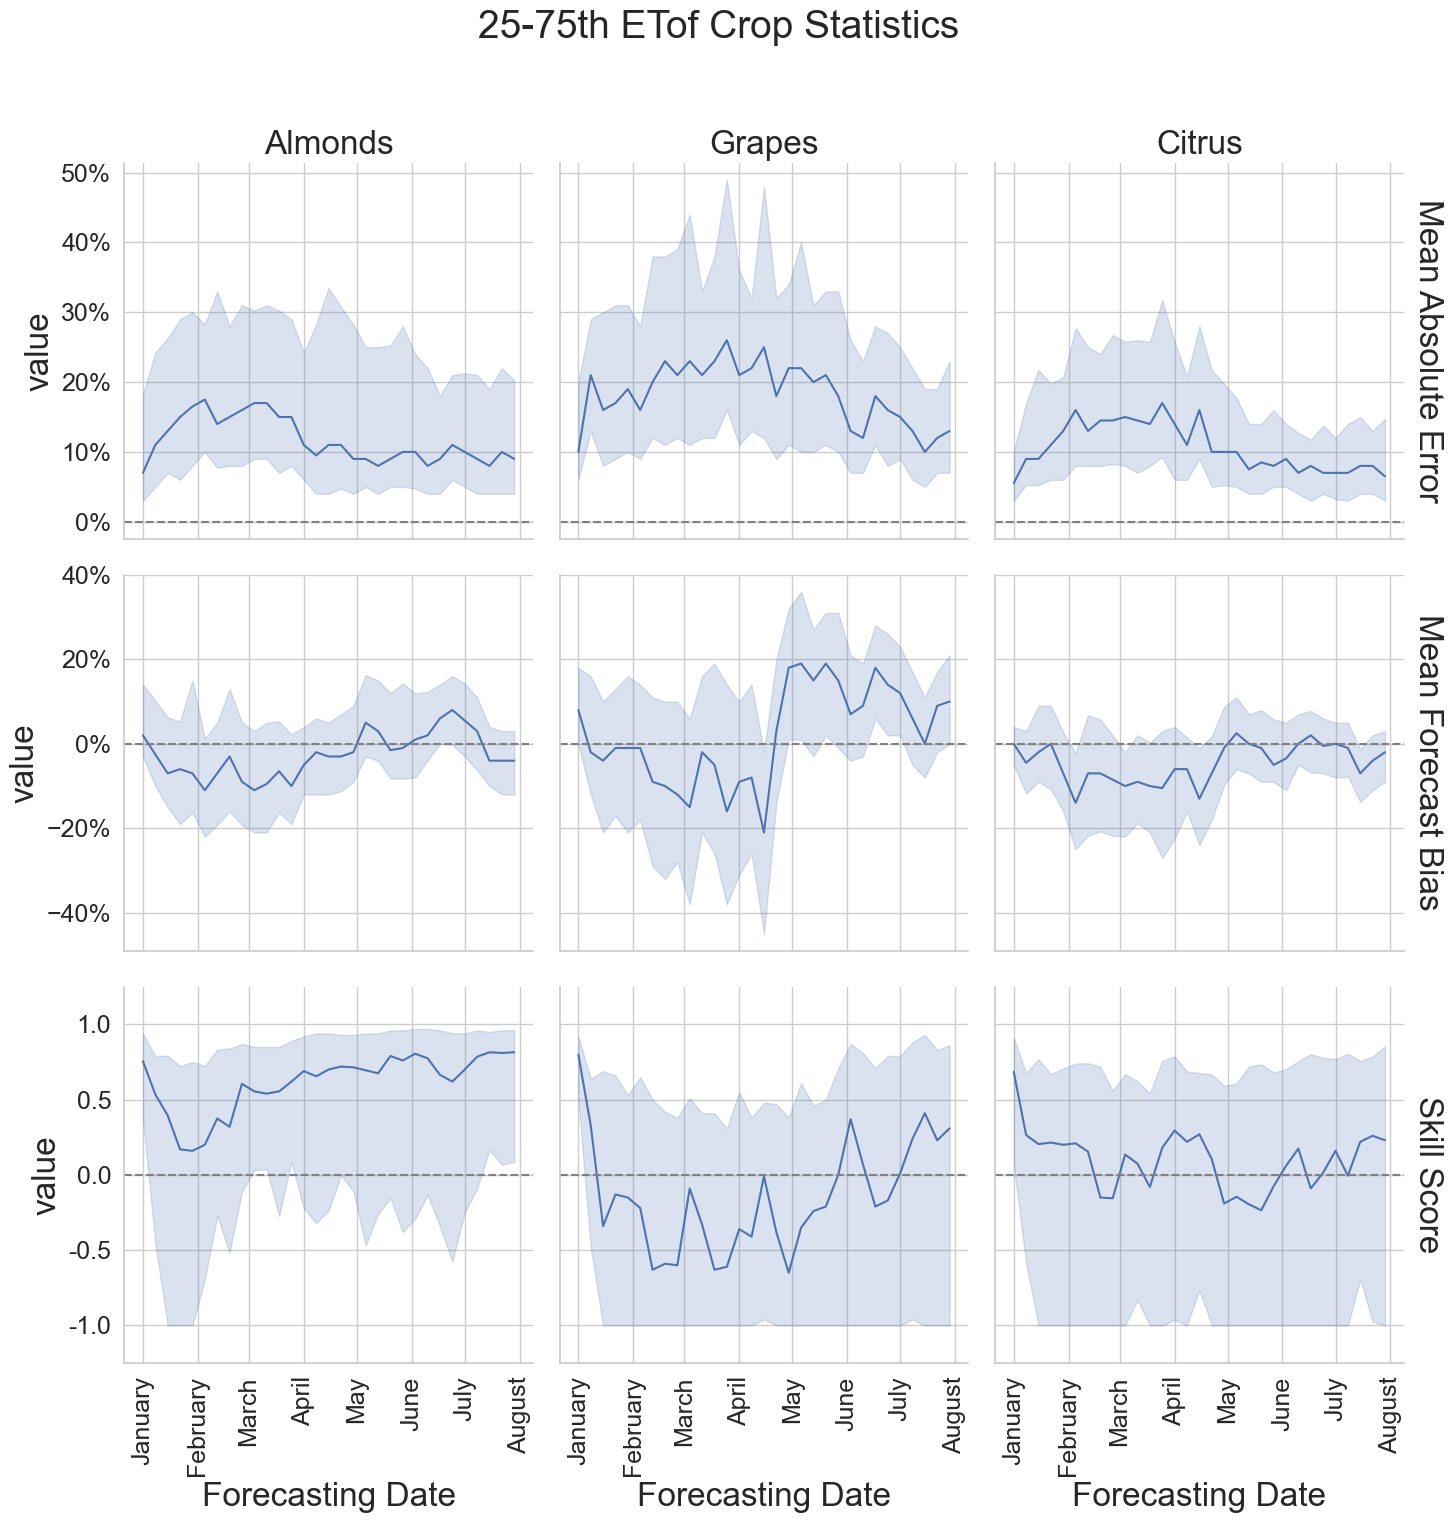

In [158]:
rel = timeseries_rel(crop_plotter[crop_plotter['variable'] == 'ETof'], y='value', plot='rel', kind='line', errorbar=('pi', 50),
                            col='Class_Names', row='name', facet_kws={'sharey': 'row', 'sharex': True, 'margin_titles': True},
                            refline={'y': 0},
                            estimator=np.median, export_img="etof_crop_metrics", title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                            title='25-75th ETof Crop Statistics', as_percent=True);
rel.axes.flat[7].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[7].set(ylim=(-1.25, 1.25));
rel.axes.flat[7].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig("images/kern/etof_crop_stats.png")

## Alignment

In [159]:
df = dt[(dt['time'] >= (dt['forecasting_date'])) & (dt['time'] < (dt['forecasting_date']) + timedelta(days=7))]
df = df.sort_values(by=['forecasting_date', 'field_id'])
df.head()

forecasting_date  field_id  crop       time  actual_et  actual_eto  \
11924280       2024-01-01  CA_27267    61 2024-01-01      0.043       0.951   
11924281       2024-01-01  CA_27267    61 2024-01-02      0.030       0.740   
11924282       2024-01-01  CA_27267    61 2024-01-03      0.062       1.691   
11924283       2024-01-01  CA_27267    61 2024-01-04      0.062       1.902   
11924284       2024-01-01  CA_27267    61 2024-01-05      0.039       1.374   

          actual_etof  expected_et  expected_eto  expected_etof  \
11924280        0.045        0.043         0.951          0.045   
11924281        0.041        0.388         1.374          0.258   
11924282        0.037        0.423         1.321          0.260   
11924283        0.032        0.451         1.253          0.261   
11924284        0.028        0.447         1.242          0.263   

                   Class_Names  ESRI_Red  ESRI_Green  ESRI_Blue  Erdas_Red  \
11924280  Fallow/Idle Cropland       191         191        122      0.749   
11924281  Fallow/Idle Cropland       191         191        122      0.749   
11924282  Fallow/Idle Cropland       191         191        122      0.749   
11924283  Fallow/Idle Cropland       191         191        122      0.749   
11924284  Fallow/Idle Cropland       191         191        122      0.749   

          Erdas_Green  Erdas_Blue  hectares  
11924280        0.749      0.4667     2.051  
11924281        0.749      0.4667     2.051  
11924282        0.749      0.4667     2.051  
11924283        0.749      0.4667     2.051  
11924284        0.749      0.4667     2.051

In [160]:
def align_forecast(data: pd.DataFrame, adjustment=0.9):
    recorded_et = data.head(1)['actual_et'].values[0]
    recorded_eto = data.head(1)['actual_eto'].values[0]
    recorded_etof = data.head(1)['actual_etof'].values[0]

    first_et = data.head(1)['expected_et'].values[0]
    first_eto = data.head(1)['expected_eto'].values[0]
    first_etof = data.head(1)['expected_etof'].values[0]
    
    # last_obs: 0.543
    # first_f: 0.750
    # calc = (0.750 - 0.543) * 0.9 = 0.207 * 0.9 = 0.1863
    
    # get the difference of just the first forecasted date and apply it to the rest of the forecasting period
    data['expected_et'] = data['expected_et'] - (first_et - recorded_et)
    data['expected_eto'] = data['expected_eto'] - (first_eto - recorded_eto)
    data['expected_etof'] = data['expected_etof'] - (first_etof - recorded_etof)

    return data[['field_id', 'crop', 'time', 'actual_et', 'actual_eto', 'actual_etof', 'expected_et', 'expected_eto', 'expected_etof', 'Class_Names', 'ESRI_Red', 'ESRI_Green', 'ESRI_Blue', 'Erdas_Red', 'Erdas_Green', 'Erdas_Blue', 'hectares']]

In [161]:
df = df.groupby('forecasting_date').apply(align_forecast).reset_index().drop(columns='level_1')
df.head()

C:\Users\Robin Fishman\AppData\Local\Temp\ipykernel_36312\1564193808.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('forecasting_date').apply(align_forecast).reset_index().drop(columns='level_1')


forecasting_date  field_id  crop       time  actual_et  actual_eto  \
0       2024-01-01  CA_27267    61 2024-01-01      0.043       0.951   
1       2024-01-01  CA_27267    61 2024-01-02      0.030       0.740   
2       2024-01-01  CA_27267    61 2024-01-03      0.062       1.691   
3       2024-01-01  CA_27267    61 2024-01-04      0.062       1.902   
4       2024-01-01  CA_27267    61 2024-01-05      0.039       1.374   

   actual_etof  expected_et  expected_eto  expected_etof  \
0        0.045        0.043         0.951          0.045   
1        0.041        0.388         1.374          0.258   
2        0.037        0.423         1.321          0.260   
3        0.032        0.451         1.253          0.261   
4        0.028        0.447         1.242          0.263   

            Class_Names  ESRI_Red  ESRI_Green  ESRI_Blue  Erdas_Red  \
0  Fallow/Idle Cropland       191         191        122      0.749   
1  Fallow/Idle Cropland       191         191        122      0.749   
2  Fallow/Idle Cropland       191         191        122      0.749   
3  Fallow/Idle Cropland       191         191        122      0.749   
4  Fallow/Idle Cropland       191         191        122      0.749   

   Erdas_Green  Erdas_Blue  hectares  
0        0.749      0.4667     2.051  
1        0.749      0.4667     2.051  
2        0.749      0.4667     2.051  
3        0.749      0.4667     2.051  
4        0.749      0.4667     2.051

### Metric Calculation

In [162]:
# alignment_metrics = df.groupby('forecasting_date').apply(eval_metrics, normalize=True)
# alignment_metrics.to_csv('./data/metrics/kern_alignment_metrics.csv')
# alignment_metrics

In [163]:
alignment_metrics = pd.read_csv('./data/metrics/kern_alignment_metrics.csv', low_memory=False).drop(columns="Unnamed: 1")
alignment_metrics['forecasting_date'] = pd.to_datetime(alignment_metrics['forecasting_date'])
alignment_metrics.head()

forecasting_date   field_id  crop   mae  rmse  corr  bias  skill_score  \
0       2024-01-01   CA_27267    61  0.34  0.28 -0.65  0.34         0.69   
1       2024-01-01  CA_297922    75  0.08  0.08 -0.46 -0.08        -0.74   
2       2024-01-01  CA_297927    61  0.05  0.04  0.99 -0.05         0.99   
3       2024-01-01  CA_297932   204  0.16  0.11 -0.33 -0.16         0.92   
4       2024-01-01  CA_297950   204  0.29  0.19 -0.98  0.29         0.53   

  variable  
0     ETof  
1     ETof  
2     ETof  
3     ETof  
4     ETof

### Visualization

In [164]:
alignment_metrics_long = alignment_metrics.reset_index().melt(
    id_vars=['forecasting_date', 'field_id', 'crop', 'variable'], value_vars=['mae', 'bias', 'skill_score'], var_name='stat')
alignment_metrics_long

forecasting_date   field_id  crop variable         stat  value
0            2024-01-01   CA_27267    61     ETof          mae   0.34
1            2024-01-01  CA_297922    75     ETof          mae   0.08
2            2024-01-01  CA_297927    61     ETof          mae   0.05
3            2024-01-01  CA_297932   204     ETof          mae   0.16
4            2024-01-01  CA_297950   204     ETof          mae   0.29
...                 ...        ...   ...      ...          ...    ...
302989       2024-07-29   CA_42274    69       ET  skill_score   0.22
302990       2024-07-29   CA_42289    47       ET  skill_score  -1.00
302991       2024-07-29   CA_42338    47       ET  skill_score   0.05
302992       2024-07-29   CA_42345    69       ET  skill_score  -0.20
302993       2024-07-29  CA_423678    61       ET  skill_score   0.97

[302994 rows x 6 columns]

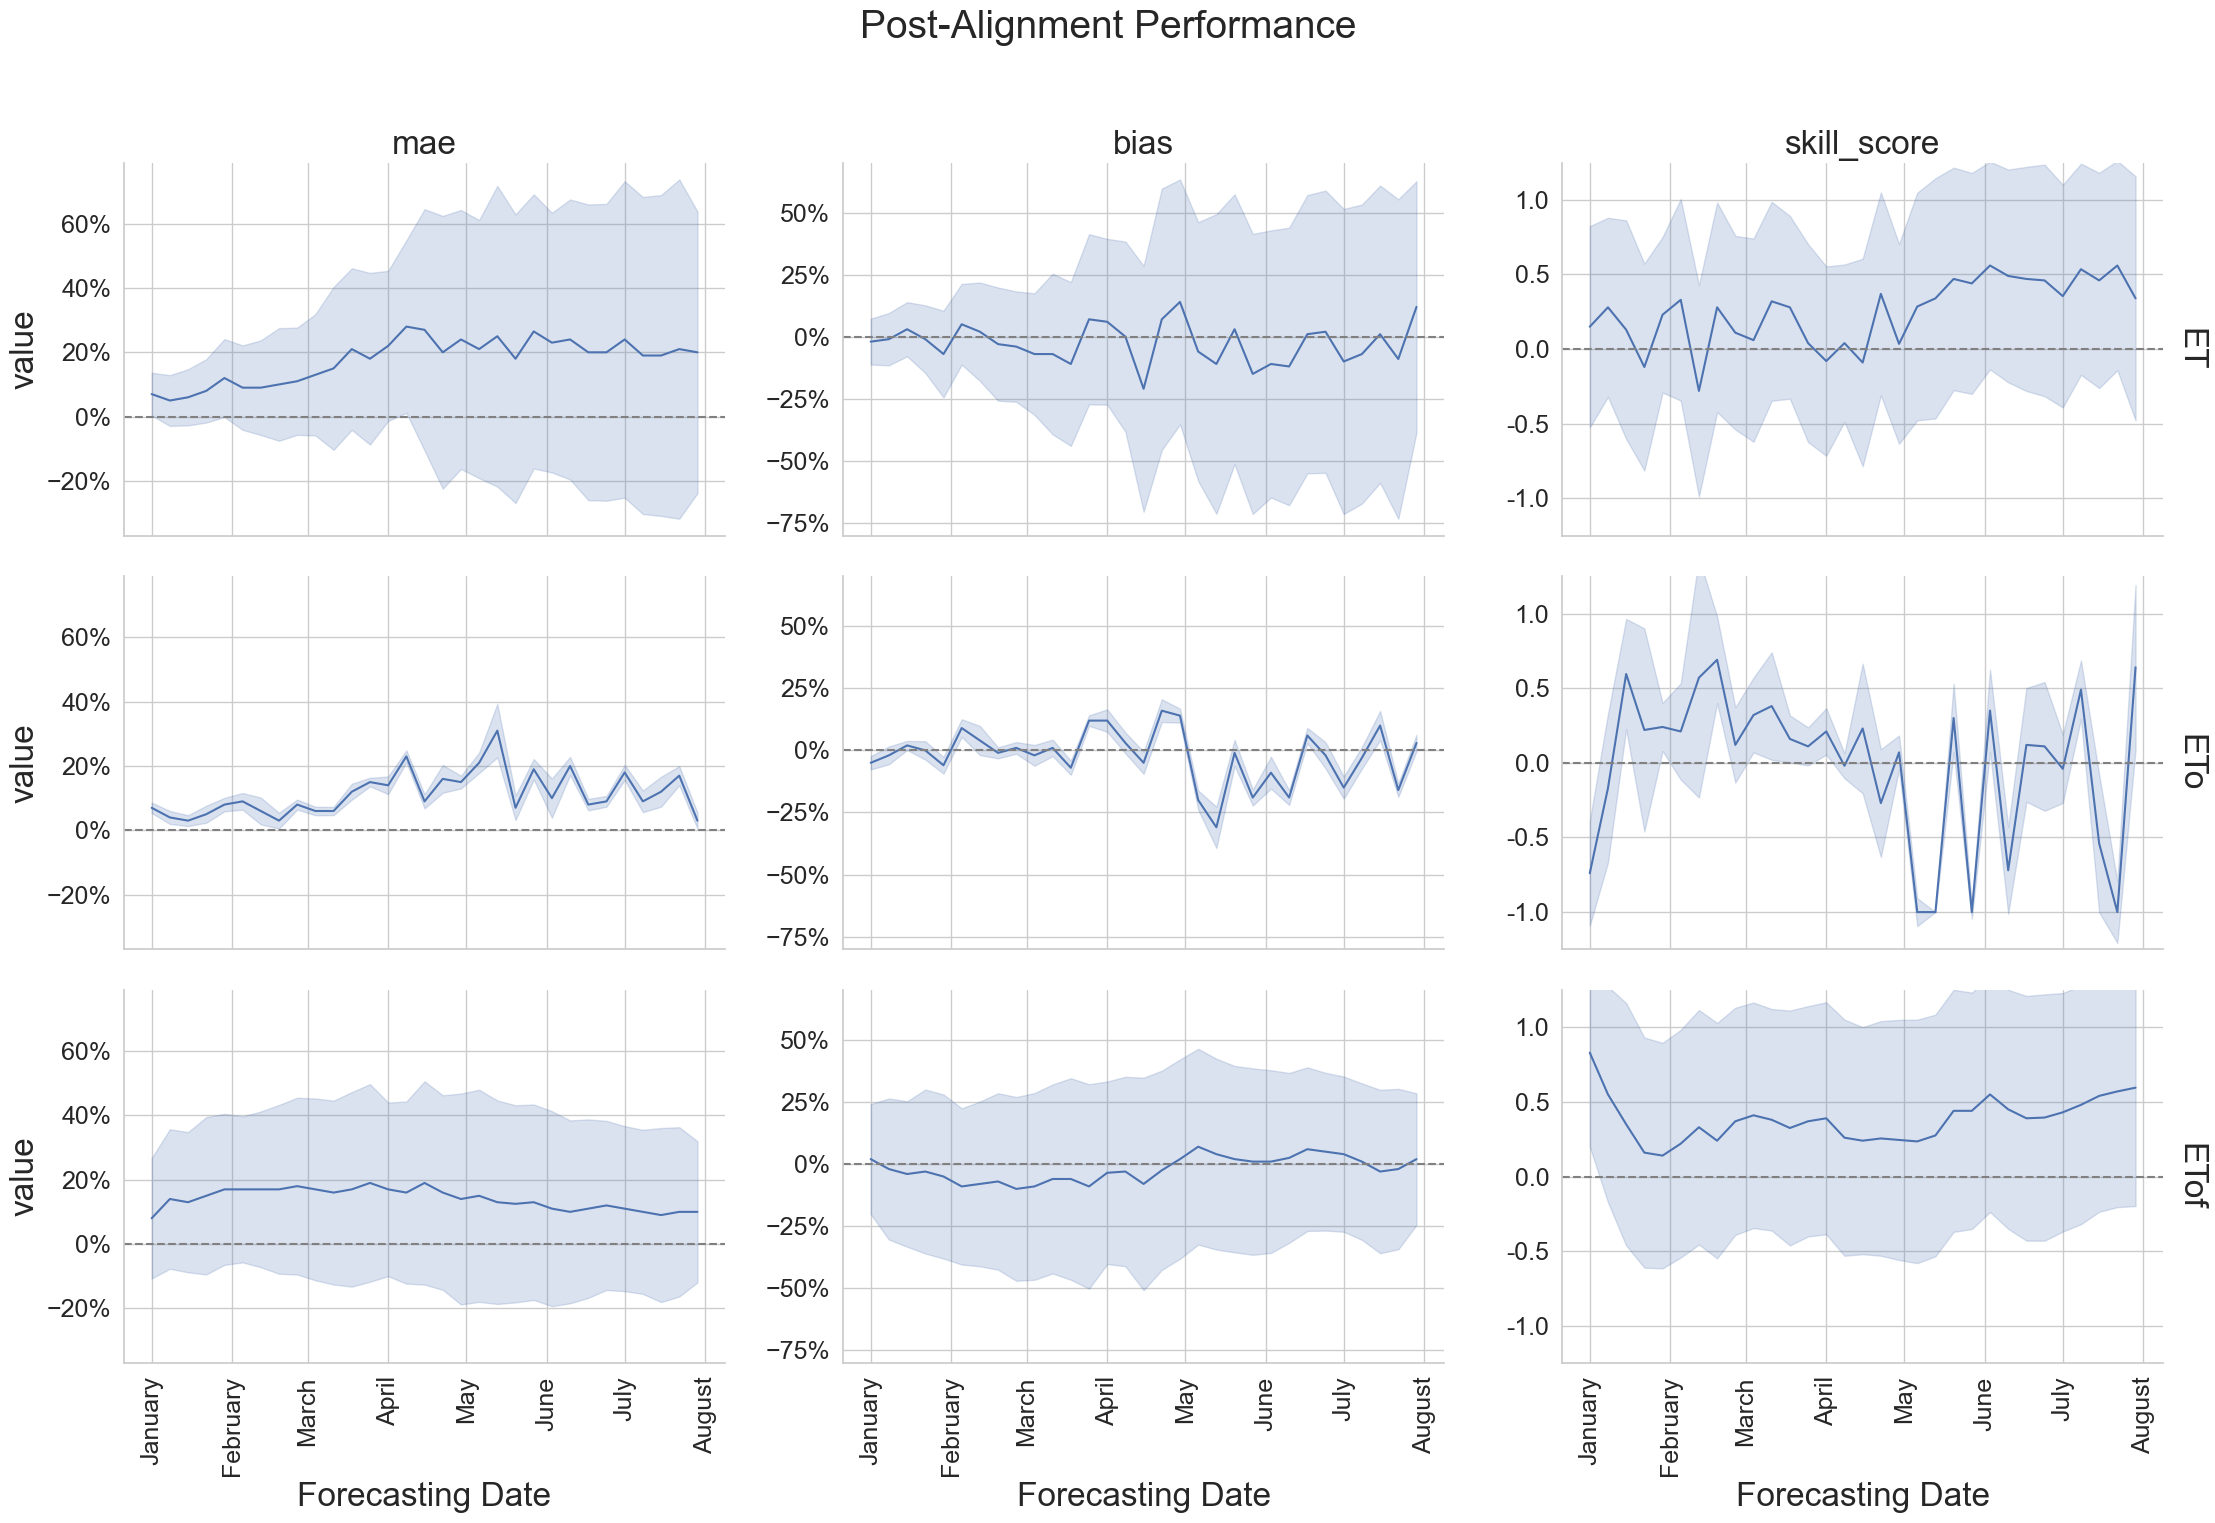

In [165]:
rel = timeseries_rel(alignment_metrics_long, row='variable', col='stat', y='value',
                     errorbar='sd', estimator=np.median, as_percent=True, aspect=1.5,
                     refline={'y': 0},
                     facet_kws={'sharey': 'col', 'sharex': True, 'margin_titles': True},
                     row_order=['ET', 'ETo', 'ETof'], title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                     title="Post-Alignment Performance");
rel.axes.flat[2].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[2].set(ylim=(-1.25, 1.25));
rel.axes.flat[2].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig('./images/kern/alignment_sd.png')

In [166]:
alignment_metrics_long['aligned'] = True
metrics_long['aligned'] = False

alignment_metrics_cmp = pd.concat([alignment_metrics_long, metrics_long])
alignment_metrics_cmp

forecasting_date   field_id  crop variable         stat  value  \
0            2024-01-01   CA_27267    61     ETof          mae   0.34   
1            2024-01-01  CA_297922    75     ETof          mae   0.08   
2            2024-01-01  CA_297927    61     ETof          mae   0.05   
3            2024-01-01  CA_297932   204     ETof          mae   0.16   
4            2024-01-01  CA_297950   204     ETof          mae   0.29   
...                 ...        ...   ...      ...          ...    ...   
302989       2024-07-29   CA_42274    69       ET  skill_score   0.22   
302990       2024-07-29   CA_42289    47       ET  skill_score  -1.00   
302991       2024-07-29   CA_42338    47       ET  skill_score  -1.00   
302992       2024-07-29   CA_42345    69       ET  skill_score  -0.57   
302993       2024-07-29  CA_423678    61       ET  skill_score   0.93   

        aligned         name           Class_Names  ESRI_Red  ESRI_Green  \
0          True          NaN                   NaN       NaN         NaN   
1          True          NaN                   NaN       NaN         NaN   
2          True          NaN                   NaN       NaN         NaN   
3          True          NaN                   NaN       NaN         NaN   
4          True          NaN                   NaN       NaN         NaN   
...         ...          ...                   ...       ...         ...   
302989    False  Skill Score                Grapes     112.0        68.0   
302990    False  Skill Score    Misc Vegs & Fruits     255.0       102.0   
302991    False  Skill Score    Misc Vegs & Fruits     255.0       102.0   
302992    False  Skill Score                Grapes     112.0        68.0   
302993    False  Skill Score  Fallow/Idle Cropland     191.0       191.0   

        ESRI_Blue  Erdas_Red  Erdas_Green  Erdas_Blue  
0             NaN        NaN          NaN         NaN  
1             NaN        NaN          NaN         NaN  
2             NaN        NaN          NaN         NaN  
3             NaN        NaN          NaN         NaN  
4             NaN        NaN          NaN         NaN  
...           ...        ...          ...         ...  
302989      137.0     0.4392       0.2667      0.5373  
302990      102.0     1.0000       0.4000      0.4000  
302991      102.0     1.0000       0.4000      0.4000  
302992      137.0     0.4392       0.2667      0.5373  
302993      122.0     0.7490       0.7490      0.4667  

[605988 rows x 15 columns]

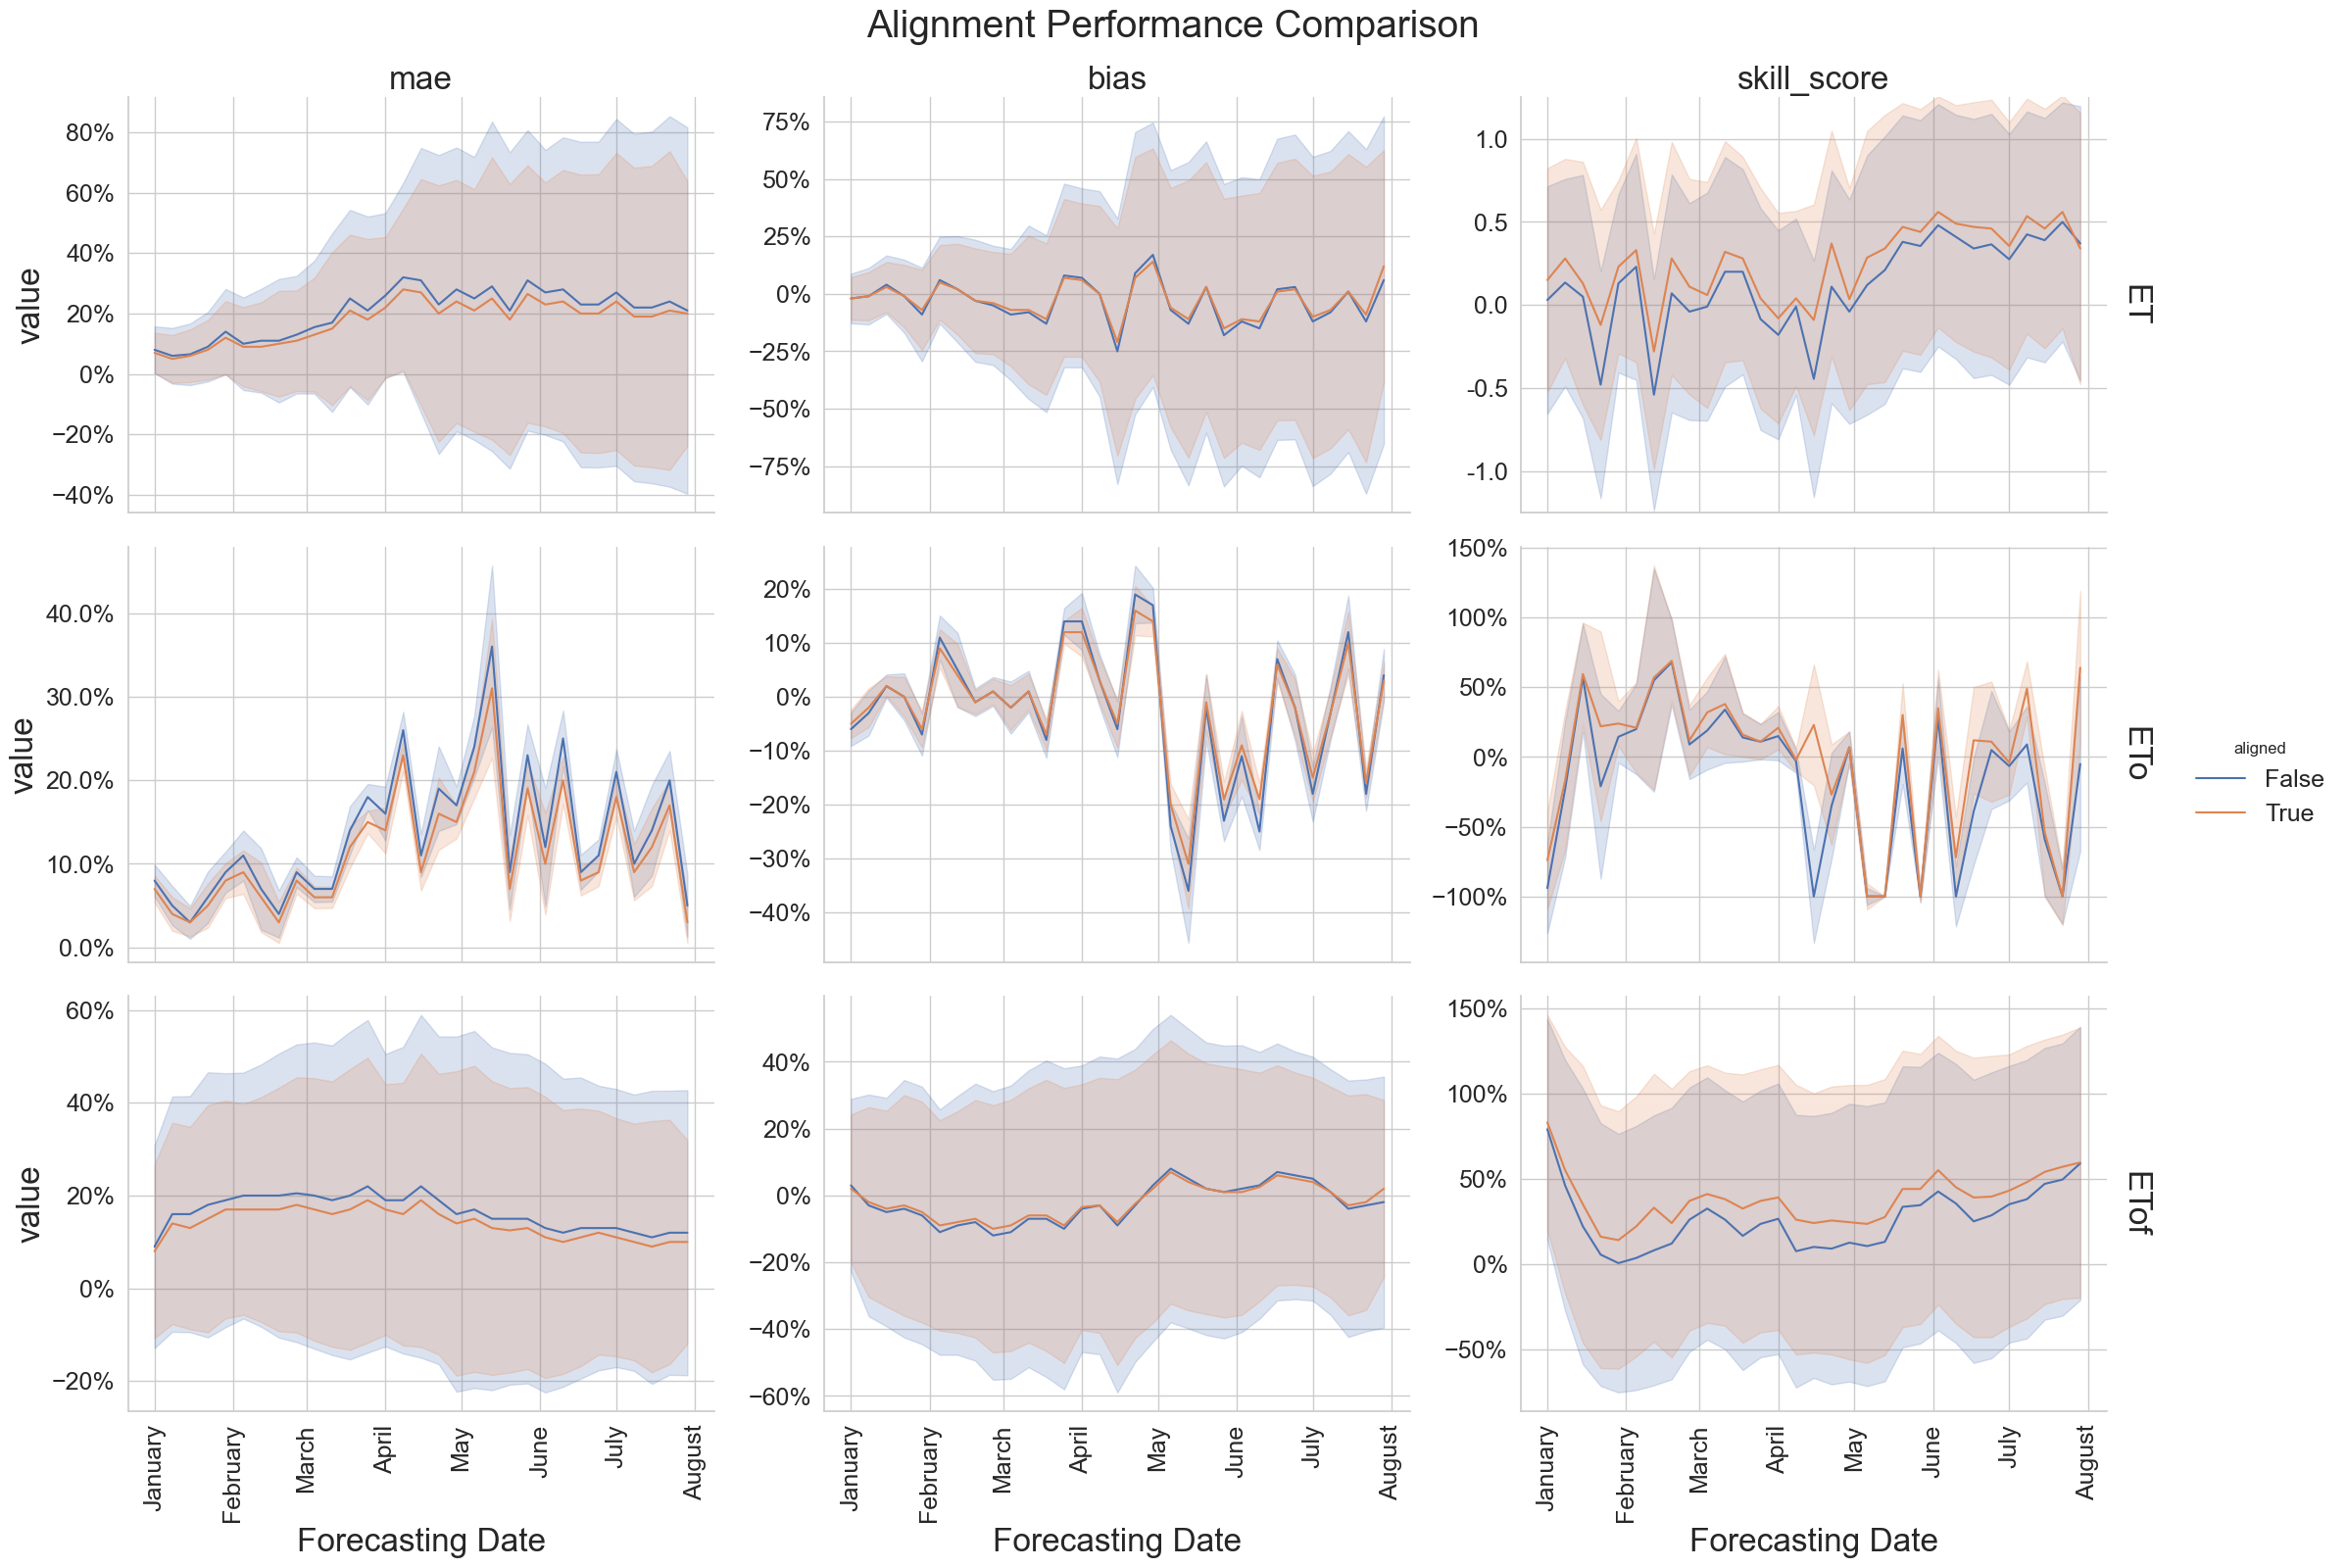

In [167]:
rel = timeseries_rel(alignment_metrics_cmp, row='variable', col='stat', y='value', hue='aligned',
                     errorbar='sd', estimator=np.median, as_percent=True, aspect=1.5,
                     facet_kws={'sharey': 'False', 'sharex': True, 'margin_titles': True},
                     row_order=['ET', 'ETo', 'ETof'], title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                     title="Alignment Performance Comparison");
rel.axes.flat[2].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[2].set(ylim=(-1.25, 1.25));
rel.axes.flat[2].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig('./images/kern/alignment_comparison.png')

## Spatial Plotting

### Preparation

First merge the geo table created in the beginning with the metrics table.

Afterwards, get the average metrics amongst all forecasts.

In [168]:
# Define date range of seasons
winter = (datetime(year=2024, month=1, day=1), datetime(year=2024, month=3, day=20)) # Start winter at start of forecast range
spring = (datetime(year=2024, month=3, day=21), datetime(year=2024, month=6, day=20))
summer = (datetime(year=2024, month=6, day=21), datetime(year=2024, month=9, day=20))

# Create list of the forecast dates that fit the seasonal ranges
winter_forecasts = pd.Series([x for x in forecast_dates if x >= winter[0] and x <= winter[1]])
spring_forecasts = pd.Series([x for x in forecast_dates if x >= spring[0] and x <= spring[1]])
summer_forecasts = pd.Series([x for x in forecast_dates if x >= summer[0] and x <= summer[1]])

def assign_season(x):
    season = ""
    if winter_forecasts.isin([x['forecasting_date']]).any():
        season = "Winter"
    elif spring_forecasts.isin([x['forecasting_date']]).any():
        season = "Spring"
    elif summer_forecasts.isin([x['forecasting_date']]).any():
        season = "Summer"
    return pd.Series({'season': season})

In [169]:
# Create column that defines a row's season
seasonal_metrics = metrics_norm.reset_index().sort_values(by='forecasting_date').merge(metrics_norm.reset_index().apply(assign_season, axis=1), left_index=True, right_index=True)

# Combine all forecasts for each field by getting mean of forecast metrics.
seasonal_metrics = seasonal_metrics.groupby(['field_id', 'season', 'variable'])[['mae', 'rmse', 'bias', 'corr', 'skill_score']].agg('mean').round(2)

# Add positional columns
seasonal_metrics = seasonal_metrics.join(kern_geo, how='left', on='field_id', validate='many_to_one')
# Add field size column for marker size
seasonal_metrics = seasonal_metrics.join(field_metadata, how='left', on='field_id', validate='many_to_one')
# Calculate marker size
seasonal_metrics['markersize'] = seasonal_metrics.apply(lambda x: np.max(np.divmod(x['hectares'] / 10, 10)[1], initial=2.0), axis=1)

seasonal_metrics.reset_index(inplace=True)
seasonal_metrics.dropna(inplace=True)
seasonal_metrics

field_id  season variable   mae  rmse  bias  corr  skill_score  \
0     CA_27267  Spring       ET  0.54  0.92 -0.47  0.09         0.30   
1     CA_27267  Spring      ETo  0.21  0.56 -0.08  0.24        -0.41   
2     CA_27267  Spring     ETof  0.24  0.18 -0.20  0.38         0.77   
3     CA_27267  Summer       ET  0.30  0.50  0.14  0.21        -0.47   
4     CA_27267  Summer      ETo  0.16  0.40 -0.10  0.29         0.08   
...        ...     ...      ...   ...   ...   ...   ...          ...   
9760  CA_42345  Summer      ETo  0.16  0.42 -0.02 -0.23        -0.49   
9761  CA_42345  Summer     ETof  0.15  0.12  0.15 -0.08         0.35   
9762  CA_42345  Winter       ET  0.12  0.23 -0.08  0.27        -0.44   
9763  CA_42345  Winter      ETo  0.08  0.21 -0.02  0.28        -0.13   
9764  CA_42345  Winter     ETof  0.25  0.22 -0.18  0.25        -0.28   

       longitude   latitude  hectares  markersize  
0    -119.969497  35.792434     2.051         2.0  
1    -119.969497  35.792434     2.051         2.0  
2    -119.969497  35.792434     2.051         2.0  
3    -119.969497  35.792434     2.051         2.0  
4    -119.969497  35.792434     2.051         2.0  
...          ...        ...       ...         ...  
9760 -119.195191  35.086790     2.762         2.0  
9761 -119.195191  35.086790     2.762         2.0  
9762 -119.195191  35.086790     2.762         2.0  
9763 -119.195191  35.086790     2.762         2.0  
9764 -119.195191  35.086790     2.762         2.0  

[9764 rows x 12 columns]

#### Import regional polygon

In [170]:
keco_geo = gpd.read_file("./data/geo/Kern_County_Boundary.geojson")
keco_geo

FID  Kern_KERN_  PERIMETER    ACRES       MUNICI_ID  AREA_SQMI  ACRES_1  \
0    1           0          0  5223552  COUNTY OF KERN     8161.8        0   

     SHAPE_area     SHAPE_len   Shape__Area  Shape__Length  \
0  227638346939  2.305833e+06  3.185696e+10  862020.384235   

                                            geometry  
0  POLYGON ((-120.19438 35.78937, -120.17914 35.7...

#### FacetGrid Geo Helper

In [171]:
def facet_geoscatter(data, *, boundary_map, col, row=None, hue, palette="YlOrRd", size=8,
                     title, export_img: bool|str=None, height=4, aspect=1.2, double_legend=False,
                     row_order=None, col_order=None, title_template={}, as_percent=True,
                     normalize_cmap=False):
    g = sns.FacetGrid(data, col=col, row=row, height=height, aspect=aspect, despine=False, row_order=row_order, col_order=col_order)
    for ax in g.axes.flat:
     boundary_map.plot(color="lightgrey", ax=ax)

    norm = None
    
    if normalize_cmap:
        norm = mcolors.TwoSlopeNorm(vcenter=0, vmin=data[hue].min(), vmax=data[hue].max())
        c_mappable = cm.ScalarMappable(norm=norm, cmap=palette)
        c_mappable.set_array(data[hue])
    else: 
        c_mappable = plt.scatter([], [], c=[], vmin=data[hue].min(), vmax=data[hue].max(), cmap=palette);

    g.map_dataframe(sns.scatterplot, x="longitude", y="latitude", hue=hue, hue_norm=norm, palette=palette, linewidths=0, size=size);
    g.tick_params(axis='x', rotation=90)
    g.set_titles(**title_template)
    plt.suptitle(title, y=.85);

    g.figure.subplots_adjust(right=.92)
    cax = g.fig.add_axes([.94, .25, .02, .5])
    g.figure.colorbar(c_mappable, cax=cax)
    if as_percent:
        cax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    if double_legend is not False:
        g.figure.subplots_adjust(right=.90)
        dax = cax.twinx()
        if type(double_legend) is not bool:
            dax.set(ylim=(double_legend.min()['value'], double_legend.max()['value']))

    if type(export_img) is bool and save is True: g.savefig(f'images/kern/{title}.png')
    elif type(export_img) is str: g.savefig(f'images/kern/{export_img}.png')
    
    return g

In [172]:
plt.rcdefaults()

### Seasonal Overview

#### ET Visualization

In [173]:
et_seasonal = seasonal_metrics[seasonal_metrics['variable'] == 'ET']

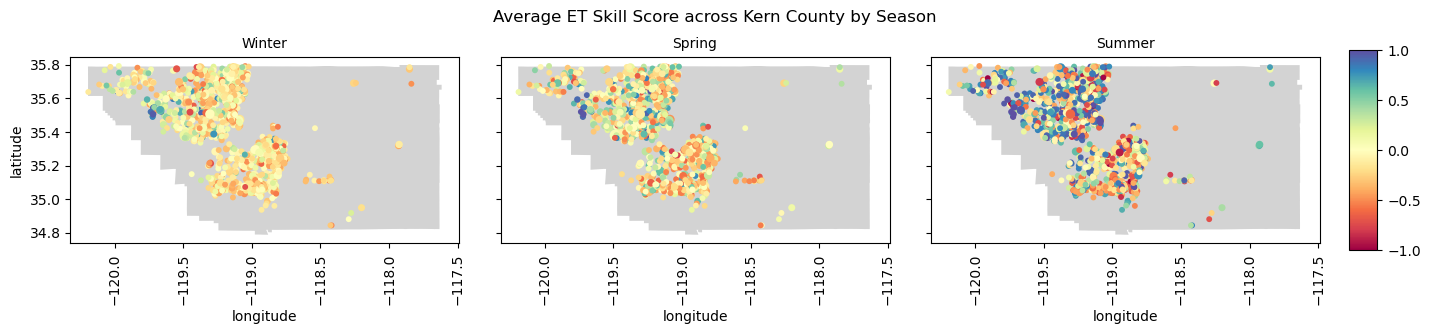

In [174]:
facet_geoscatter(et_seasonal, boundary_map=keco_geo, col='season', hue='skill_score', palette='Spectral', size='markersize',
                 as_percent=False, normalize_cmap=True, export_img="et_spatial_skill_score", 
                 col_order=['Winter', 'Spring', 'Summer'], title_template={"template":"{col_name}"},
                 title="Average ET Skill Score across Kern County by Season");

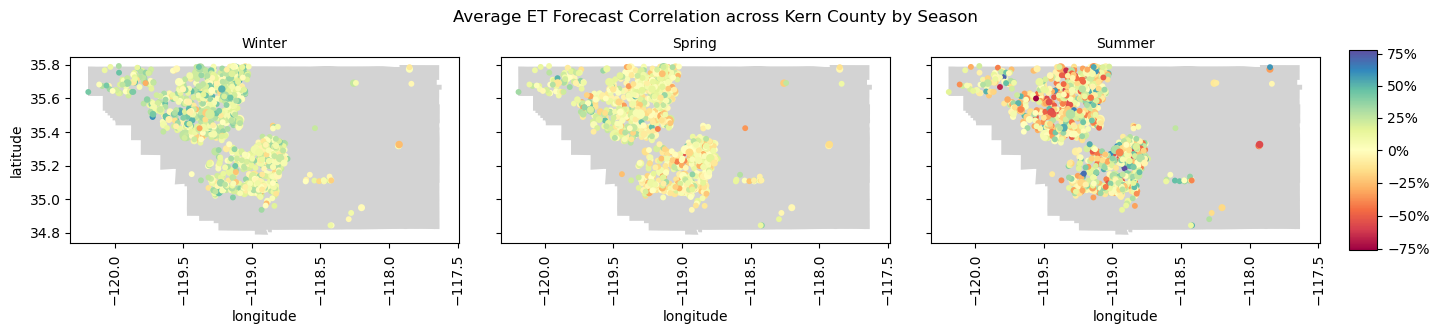

In [175]:
facet_geoscatter(et_seasonal, boundary_map=keco_geo, col='season', hue='corr', export_img="et_spatial_corr", size='markersize',
                     col_order=['Winter', 'Spring', 'Summer'], normalize_cmap=True, title_template={"template":"{col_name}"},
                     title="Average ET Forecast Correlation across Kern County by Season", palette='Spectral');

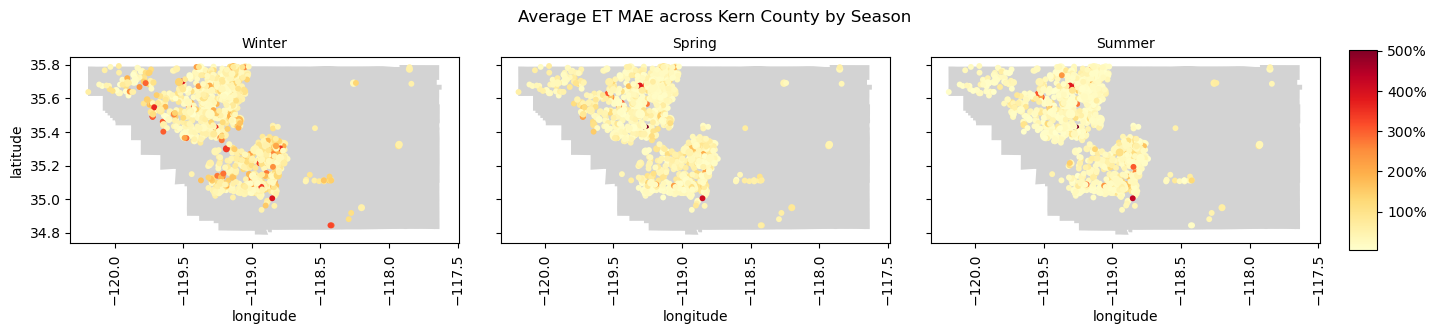

In [176]:
facet_geoscatter(et_seasonal, boundary_map=keco_geo, col='season', hue='mae',export_img="et_spatial_mae", size='markersize',
                     col_order=['Winter', 'Spring', 'Summer'], title_template={"template":"{col_name}"},
                     title="Average ET MAE across Kern County by Season");

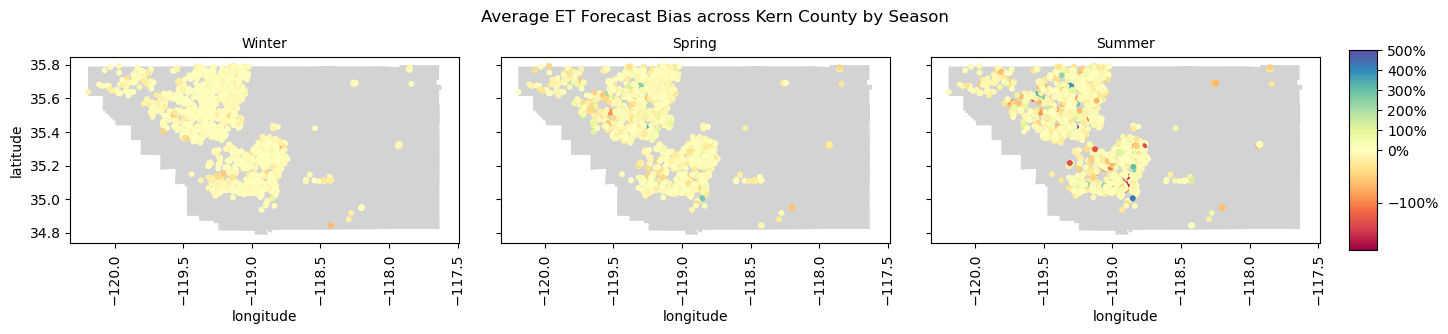

In [177]:
facet_geoscatter(et_seasonal, boundary_map=keco_geo, col='season', hue='bias', palette='Spectral', export_img="et_spatial_bias", size='markersize',
                     col_order=['Winter', 'Spring', 'Summer'], normalize_cmap=True, title_template={"template":"{col_name}"},
                     title="Average ET Forecast Bias across Kern County by Season");

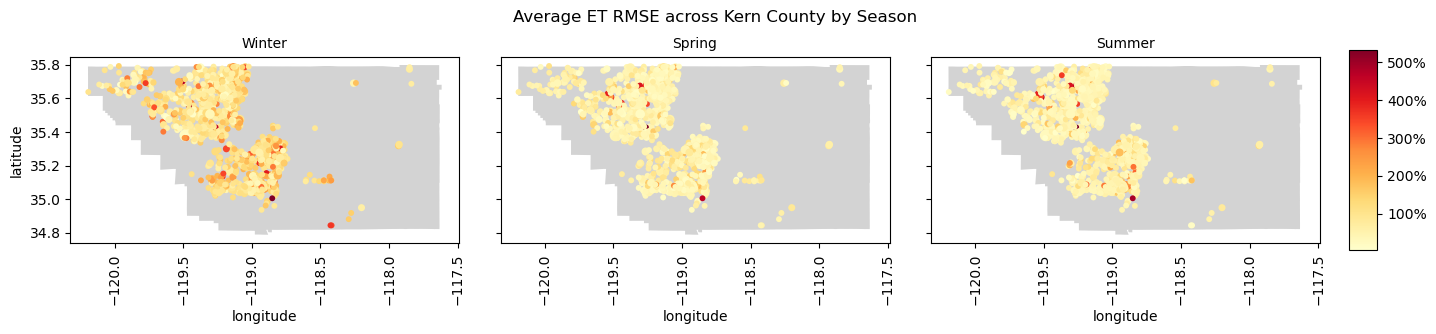

In [178]:
facet_geoscatter(et_seasonal, boundary_map=keco_geo, col='season', hue='rmse', export_img="et_spatial_rmse", size='markersize',
                     col_order=['Winter', 'Spring', 'Summer'], title_template={"template":"{col_name}"},
                     title="Average ET RMSE across Kern County by Season");

#### ETo Visualization

In [179]:
eto_seasonal = seasonal_metrics[seasonal_metrics['variable'] == 'ETo']

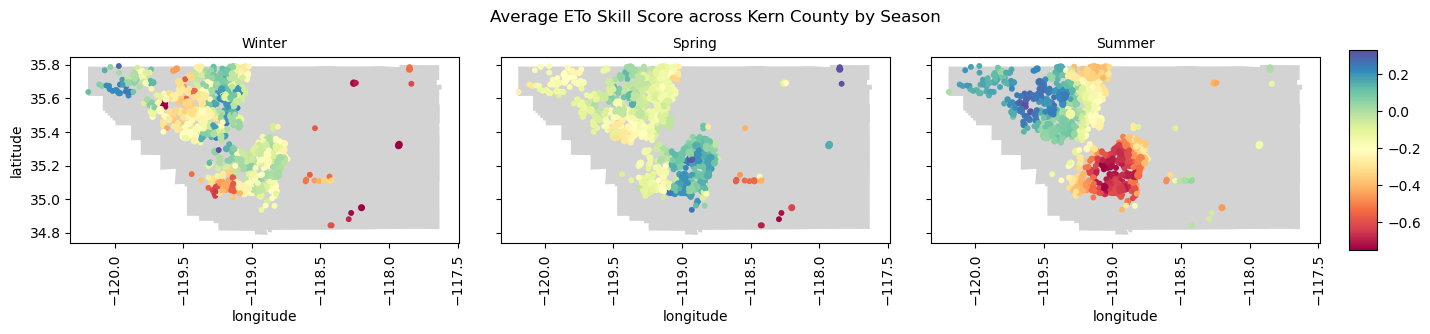

In [180]:
facet_geoscatter(eto_seasonal, boundary_map=keco_geo, col='season', hue='skill_score', export_img="eto_spatial_skill_score", as_percent=False, size='markersize',
                     col_order=['Winter', 'Spring', 'Summer'], title_template={"template":"{col_name}"}, # normalize_cmap=True,
                     title="Average ETo Skill Score across Kern County by Season", palette='Spectral');

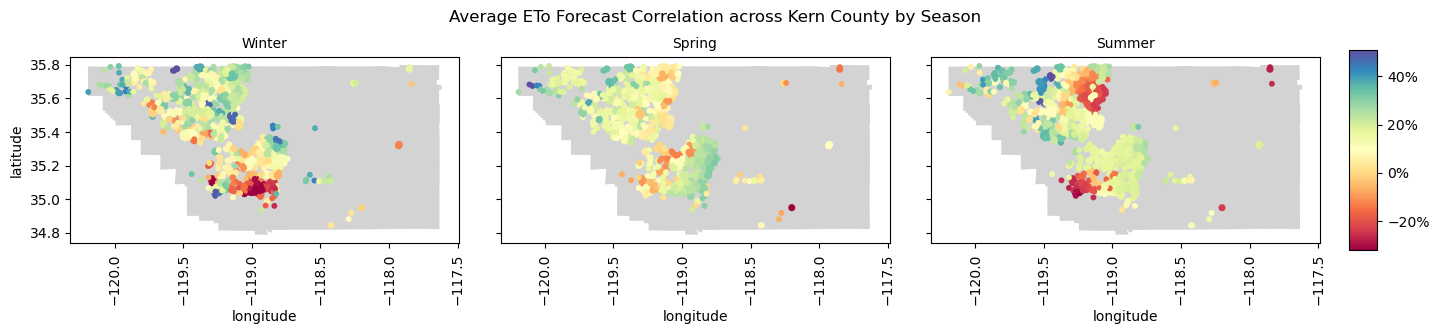

In [181]:
facet_geoscatter(eto_seasonal, boundary_map=keco_geo, col='season', hue='corr', export_img="eto_spatial_corr", size='markersize',
                     col_order=['Winter', 'Spring', 'Summer'], title_template={"template":"{col_name}"},# normalize_cmap=True,
                     title="Average ETo Forecast Correlation across Kern County by Season", palette='Spectral');

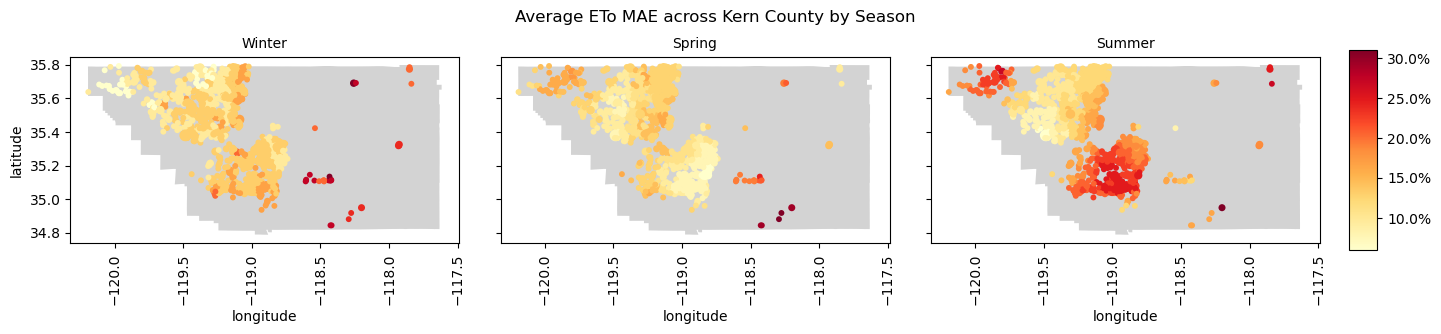

In [182]:
facet_geoscatter(eto_seasonal, boundary_map=keco_geo, col='season', hue='mae',export_img="eto_spatial_mae", size='markersize',
                     col_order=['Winter', 'Spring', 'Summer'], title_template={"template":"{col_name}"},
                     title="Average ETo MAE across Kern County by Season");

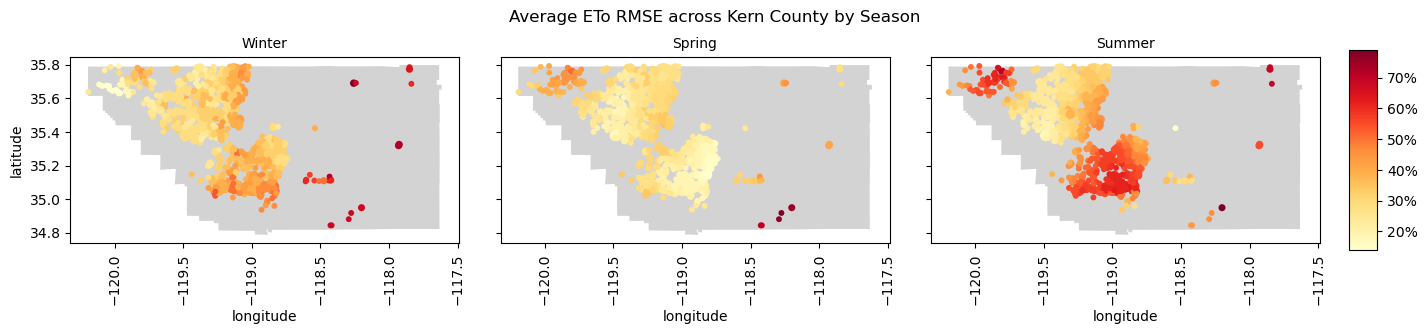

In [183]:
facet_geoscatter(eto_seasonal, boundary_map=keco_geo, col='season', hue='rmse', export_img="eto_spatial_rmse", size='markersize',
                     col_order=['Winter', 'Spring', 'Summer'], title_template={"template":"{col_name}"},
                     title="Average ETo RMSE across Kern County by Season");

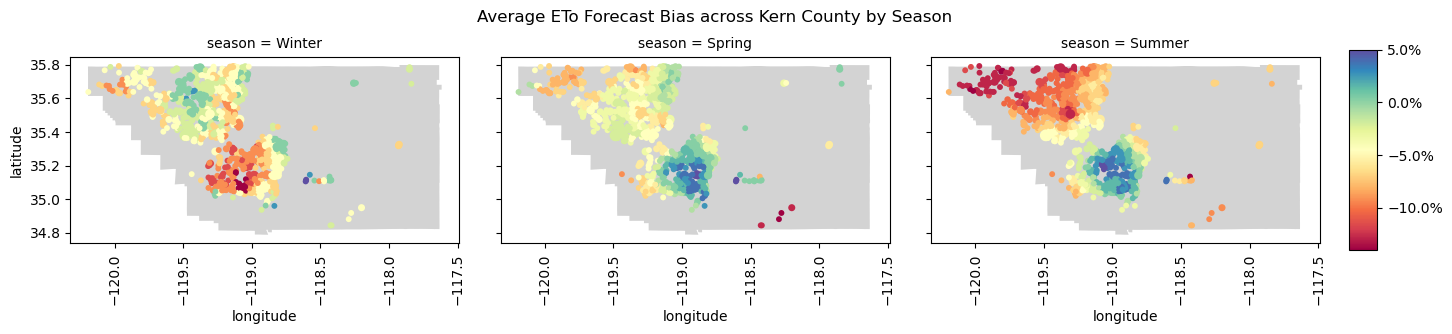

In [184]:
facet_geoscatter(eto_seasonal, boundary_map=keco_geo, col='season', hue='bias', palette='Spectral', export_img="eto_spatial_bias", size='markersize',
                     col_order=['Winter', 'Spring', 'Summer'],# normalize_cmap=True, title_template={"template":"{col_name}"},
                     title="Average ETo Forecast Bias across Kern County by Season");

#### EToF Visualization

In [185]:
etof_seasonal = seasonal_metrics[seasonal_metrics['variable'] == 'ETof']

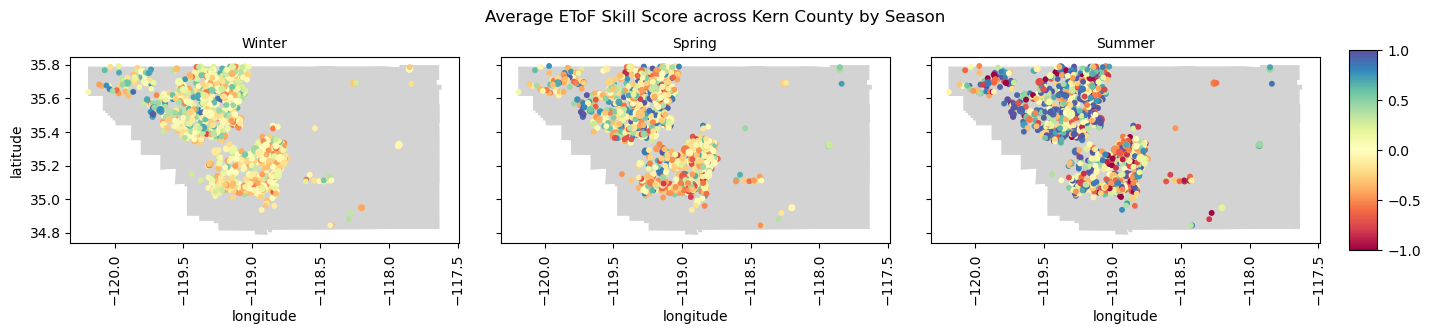

In [186]:
facet_geoscatter(etof_seasonal, boundary_map=keco_geo, col='season', hue='skill_score', size='markersize', export_img="etof_spatial_skill_score", as_percent=False,
                     col_order=['Winter', 'Spring', 'Summer'], normalize_cmap=True, title_template={"template":"{col_name}"},
                     title="Average EToF Skill Score across Kern County by Season", palette='Spectral');

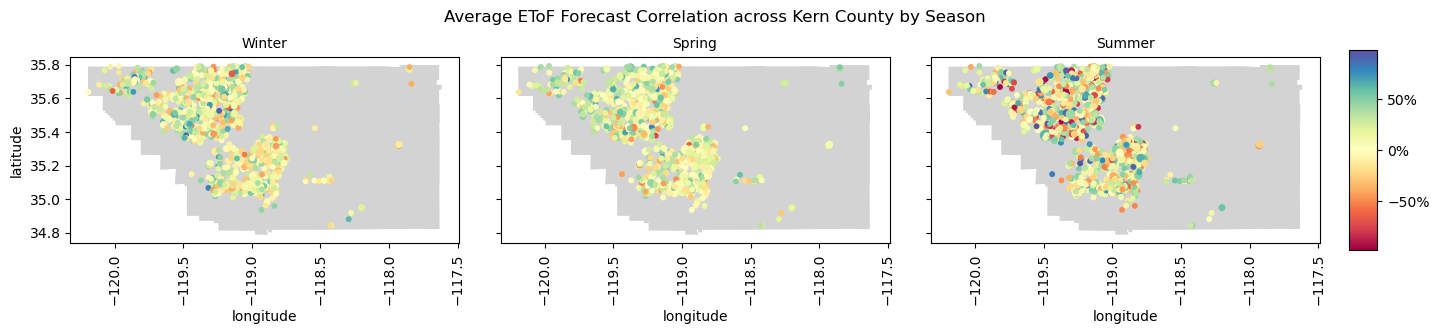

In [187]:
facet_geoscatter(etof_seasonal, boundary_map=keco_geo, col='season', hue='corr', size='markersize', export_img="etof_spatial_corr",
                     col_order=['Winter', 'Spring', 'Summer'], normalize_cmap=True, title_template={"template":"{col_name}"},
                     title="Average EToF Forecast Correlation across Kern County by Season", palette='Spectral');

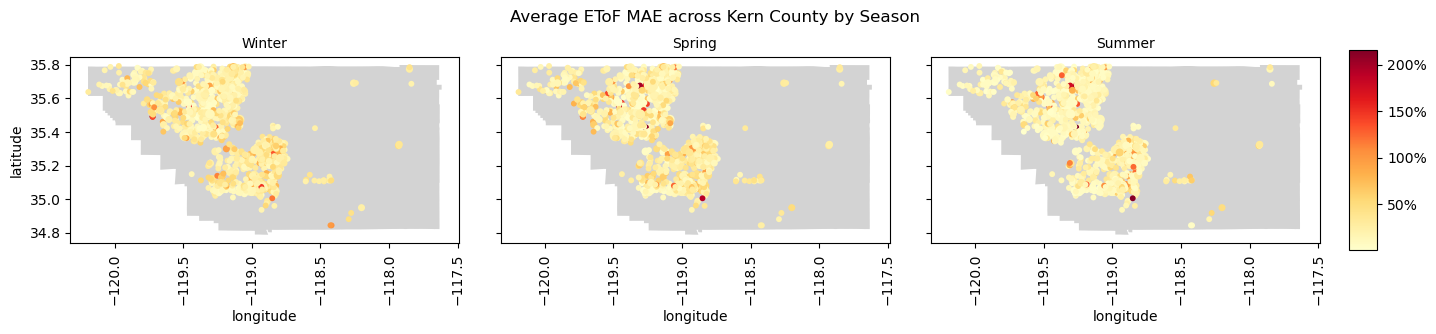

In [188]:
facet_geoscatter(etof_seasonal, boundary_map=keco_geo, col='season', hue='mae', size='markersize', export_img="etof_spatial_mae",
                     col_order=['Winter', 'Spring', 'Summer'], title_template={"template":"{col_name}"},
                     title="Average EToF MAE across Kern County by Season");

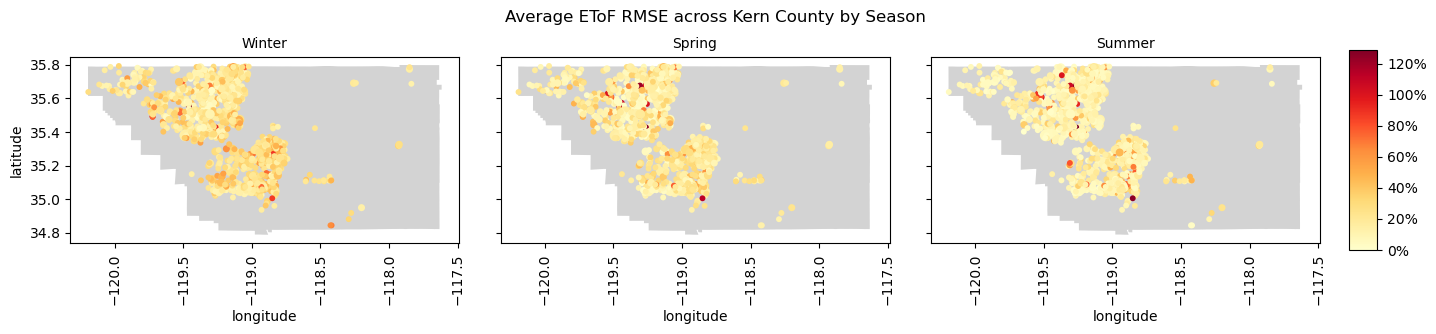

In [189]:
facet_geoscatter(etof_seasonal, boundary_map=keco_geo, col='season', hue='rmse', size='markersize', export_img="etof_spatial_rmse",
                     col_order=['Winter', 'Spring', 'Summer'], title_template={"template":"{col_name}"},
                     title="Average EToF RMSE across Kern County by Season");

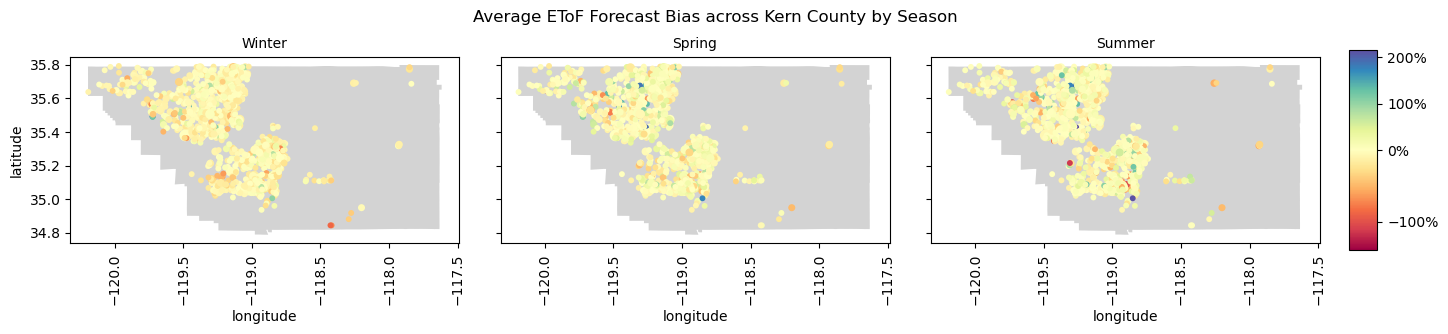

In [190]:
facet_geoscatter(etof_seasonal, boundary_map=keco_geo, col='season', hue='bias', size='markersize', palette='Spectral', export_img="etof_spatial_bias",
                     col_order=['Winter', 'Spring', 'Summer'], normalize_cmap=True, title_template={"template":"{col_name}"},
                     title="Average EToF Forecast Bias across Kern County by Season");

#### Summer Overview

In [191]:
summer_metrics = seasonal_metrics[seasonal_metrics['season'] == 'Summer'][['field_id', 'variable', 'longitude', 'latitude', 'mae', 'bias', 'skill_score', 'markersize']]
summer_metrics = summer_metrics.melt(id_vars=['field_id', 'variable', 'longitude', 'latitude', 'markersize'], value_vars=['mae', 'bias', 'skill_score'], var_name='stat')
summer_metrics.head()

field_id variable   longitude   latitude  markersize stat  value
0   CA_27267       ET -119.969497  35.792434         2.0  mae   0.30
1   CA_27267      ETo -119.969497  35.792434         2.0  mae   0.16
2   CA_27267     ETof -119.969497  35.792434         2.0  mae   0.15
3  CA_297922       ET -119.229705  35.750524         2.0  mae   0.61
4  CA_297922      ETo -119.229705  35.750524         2.0  mae   0.12

In [192]:
# Add subtitles into the data to insert into the plots
subtitle_dict = {
    'mae': 'Mean Absolute Error',
    'bias': 'Forecast Bias',
    'skill_score': 'Skill Score'
}
summer_metrics['name'] = summer_metrics['stat'].map(subtitle_dict)

In [193]:
# Keyword for double-sided legend
sm_skill_score = summer_metrics[summer_metrics['stat'] == 'skill_score']

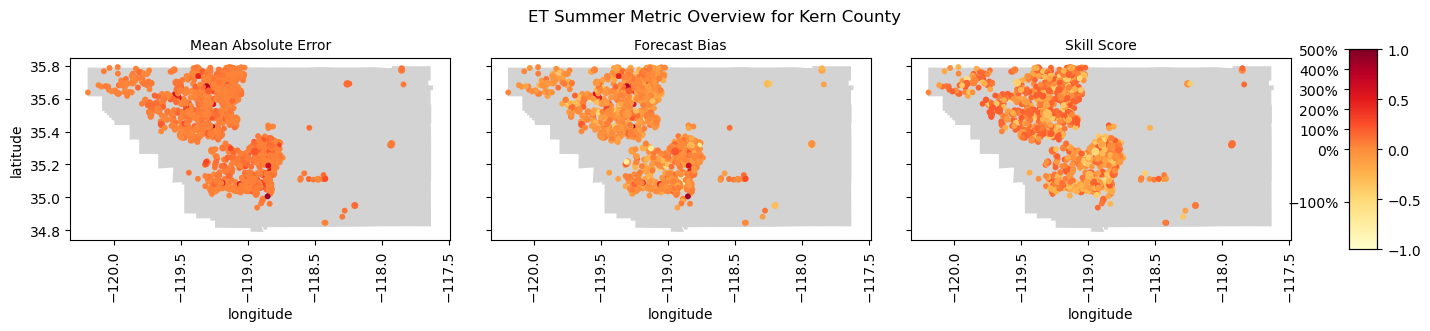

In [194]:
# Create subplot grid for each metric
g = facet_geoscatter(summer_metrics[summer_metrics['variable'] == 'ET'], boundary_map=keco_geo, col='name', hue='value', size='markersize', normalize_cmap=True,
                     title='ET Summer Metric Overview for Kern County', title_template={"template": "{col_name}"}, export_img="et_summer_spatial",
                     double_legend=sm_skill_score[sm_skill_score['variable'] == 'ET']);

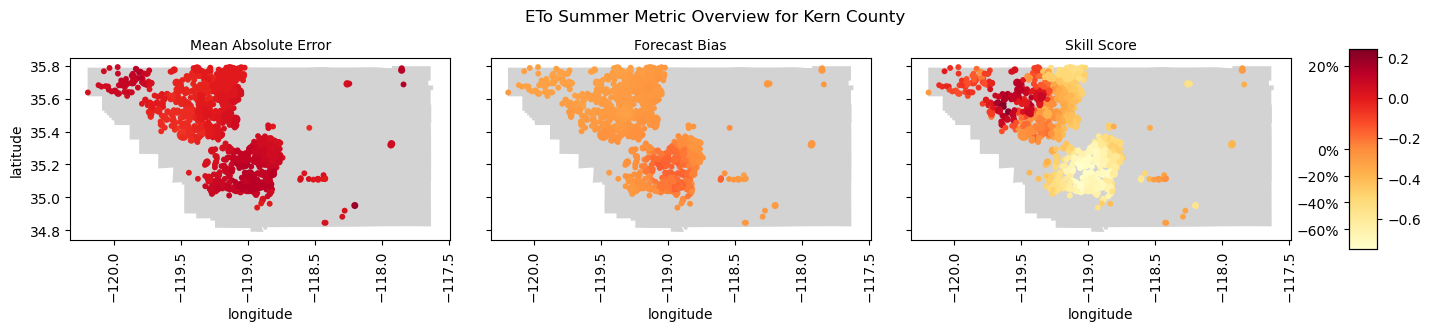

In [195]:
# Create subplot grid for each metric
g = facet_geoscatter(summer_metrics[summer_metrics['variable'] == 'ETo'], boundary_map=keco_geo, col='name', hue='value', size='markersize', normalize_cmap=True,
                     title='ETo Summer Metric Overview for Kern County', title_template={"template": "{col_name}"}, export_img="eto_summer_spatial",
                     double_legend=sm_skill_score[sm_skill_score['variable'] == 'ETo']);

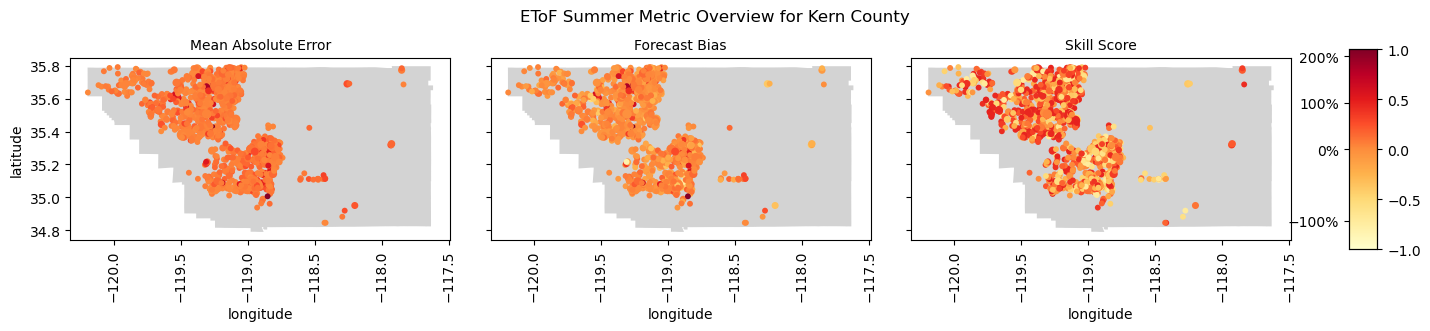

In [196]:
##### Create subplot grid for each metric
g = facet_geoscatter(summer_metrics[summer_metrics['variable'] == 'ETof'], boundary_map=keco_geo, col='name', hue='value', size='markersize', normalize_cmap=True,
                     title='EToF Summer Metric Overview for Kern County', title_template={"template": "{col_name}"}, export_img="etof_summer_spatial",
                     double_legend=sm_skill_score[sm_skill_score['variable'] == 'ETof']);

## Polygon Analysis

Polygon analysis is conducted on a set of worst performing fields based on Mean Absolute Error. This analysis is conducted to see if polygon forecasting is more accurate than point forecasting.

In [197]:
# Styling Cell
sns.set_theme(context="notebook", style="whitegrid")

SMALL_SIZE = 18
MEDIUM_SIZE = 24
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Historical Import

In [198]:
poly_historical = pd.read_csv('./data/kern_polygon_historical.csv', low_memory=False)
poly_historical['time'] = pd.to_datetime(poly_historical['time'])
poly_historical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62740 entries, 0 to 62739
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   field_id     62740 non-null  object        
 1   crop         62740 non-null  int64         
 2   time         62740 non-null  datetime64[ns]
 3   actual_et    62740 non-null  float64       
 4   actual_eto   62740 non-null  float64       
 5   actual_etof  62740 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 2.9+ MB


In [199]:
poly_fields = poly_historical['field_id'].unique()

### Forecast Table

In [200]:
# Gather current forecast data for the county
forecasting_table = pd.DataFrame()
files = Path(f"data/forecasts/0.0.1/polygon/kern/").glob("*.csv")

for file in files:
    # splits into [$date, 'forecast.csv']
    parts = str(file.name).split("_")
    data = pd.read_csv(file, low_memory=False)
    data["forecasting_date"] = parts[0]
    forecasting_table = pd.concat([data, forecasting_table], ignore_index=True)

forecasting_table['forecasting_date'] = pd.to_datetime(forecasting_table['forecasting_date'])
forecasting_table['time'] = pd.to_datetime(forecasting_table['time'])
forecasting_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226920 entries, 0 to 226919
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   field_id          226920 non-null  object        
 1   crop              226920 non-null  int64         
 2   time              226920 non-null  datetime64[ns]
 3   expected_et       226920 non-null  float64       
 4   expected_eto      226920 non-null  float64       
 5   expected_etof     226920 non-null  float64       
 6   forecasting_date  226920 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(3), int64(1), object(1)
memory usage: 12.1+ MB


### Main Table Compilation

In [201]:
poly_dt = poly_historical.loc[(poly_historical['time'].dt.year == 2024), :]
poly_dt = poly_dt.merge(forecasting_table, on=['field_id', 'time', 'crop'], how='right').set_index(['forecasting_date', 'field_id', 'crop', 'time']).reset_index()
poly_dt

forecasting_date   field_id  crop       time  actual_et  actual_eto  \
0            2024-07-29  CA_298674    75 2024-01-01      0.506       0.745   
1            2024-07-29  CA_298674    75 2024-01-02      0.369       0.558   
2            2024-07-29  CA_298674    75 2024-01-03      0.779       1.210   
3            2024-07-29  CA_298674    75 2024-01-04      0.932       1.489   
4            2024-07-29  CA_298674    75 2024-01-05      0.566       0.931   
...                 ...        ...   ...        ...        ...         ...   
226915       2024-01-01   CA_42237    47 2024-12-27        NaN         NaN   
226916       2024-01-01   CA_42237    47 2024-12-28        NaN         NaN   
226917       2024-01-01   CA_42237    47 2024-12-29        NaN         NaN   
226918       2024-01-01   CA_42237    47 2024-12-30        NaN         NaN   
226919       2024-01-01   CA_42237    47 2024-12-31        NaN         NaN   

        actual_etof  expected_et  expected_eto  expected_etof  
0             0.680        0.506         0.745          0.680  
1             0.662        0.369         0.558          0.662  
2             0.644        0.779         1.210          0.644  
3             0.626        0.932         1.489          0.626  
4             0.608        0.566         0.931          0.608  
...             ...          ...           ...            ...  
226915          NaN        0.352         0.668          0.419  
226916          NaN        0.342         0.681          0.425  
226917          NaN        0.341         0.703          0.426  
226918          NaN        0.332         0.733          0.427  
226919          NaN        0.311         0.754          0.429  

[226920 rows x 10 columns]

### Reference Tables

#### Average ET/ETo/ETof for 2024

In [202]:
poly_avgs = poly_dt.groupby(['field_id', 'crop'])[['actual_et', 'actual_eto', 'actual_etof']].agg('mean')
poly_avgs.head()

actual_et  actual_eto  actual_etof
field_id  crop                                    
CA_298674 75     2.633191    4.558130     0.565167
CA_299176 75     2.652465    4.711014     0.599149
CA_299683 75     2.637958    4.844716     0.593484
CA_299845 75     2.580879    4.598116     0.614888
CA_299867 75     2.972698    4.597749     0.556102

#### Climatology Reference

In [203]:
# Create a column for day of year
poly_historical['doy'] = poly_historical['time'].dt.dayofyear
# Group by field, crop, and doy then calculate the average conditions
poly_climatology = poly_historical.groupby(['field_id', 'crop', 'doy'])[['actual_et', 'actual_eto', 'actual_etof']].agg('mean')
poly_climatology

actual_et  actual_eto  actual_etof
field_id  crop doy                                    
CA_298674 75   1     0.516667    0.806667     0.654000
               2     0.594667    0.920556     0.646000
               3     0.678889    1.075556     0.638222
               4     0.721111    1.158222     0.630556
               5     0.636778    1.003222     0.622556
...                       ...         ...          ...
CA_42237  47   362   0.575750    1.008125     0.607000
               363   0.599750    0.955875     0.607500
               364   0.629750    1.008250     0.607875
               365   0.474375    0.785500     0.611375
               366   0.496000    0.733000     0.586500

[7320 rows x 3 columns]

### Accuracy Metric Calculation

In [204]:
poly_metrics = (poly_dt[(poly_dt['time'] > poly_dt['forecasting_date']) & (poly_dt['time'] < (poly_dt['forecasting_date']) + timedelta(days=7)) & (poly_dt['time'] < analysis_end_date)]
                .groupby(['forecasting_date'])[list(poly_dt.columns)]
                .apply(eval_metrics, normalize=True, climatology_ref=poly_climatology, avgs_ref=poly_avgs))
poly_metrics.reset_index().to_csv('data/metrics/kern_poly_metrics.csv', index=False)

C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [205]:
poly_metrics = pd.read_csv('data/metrics/kern_poly_metrics.csv').drop(['level_1'], axis=1)
poly_metrics['forecasting_date'] = pd.to_datetime(poly_metrics['forecasting_date'])

### Visualization

In [206]:
# First reshape data from wide-form to long-form
poly_metrics_long = poly_metrics.reset_index().melt(id_vars=['forecasting_date', 'field_id', 'crop', 'variable'], value_vars=['mae', 'bias', 'skill_score'], var_name='stat')
poly_metrics_long['name'] = poly_metrics_long['stat'].map(stat_propers)

#### Interquartile Metrics

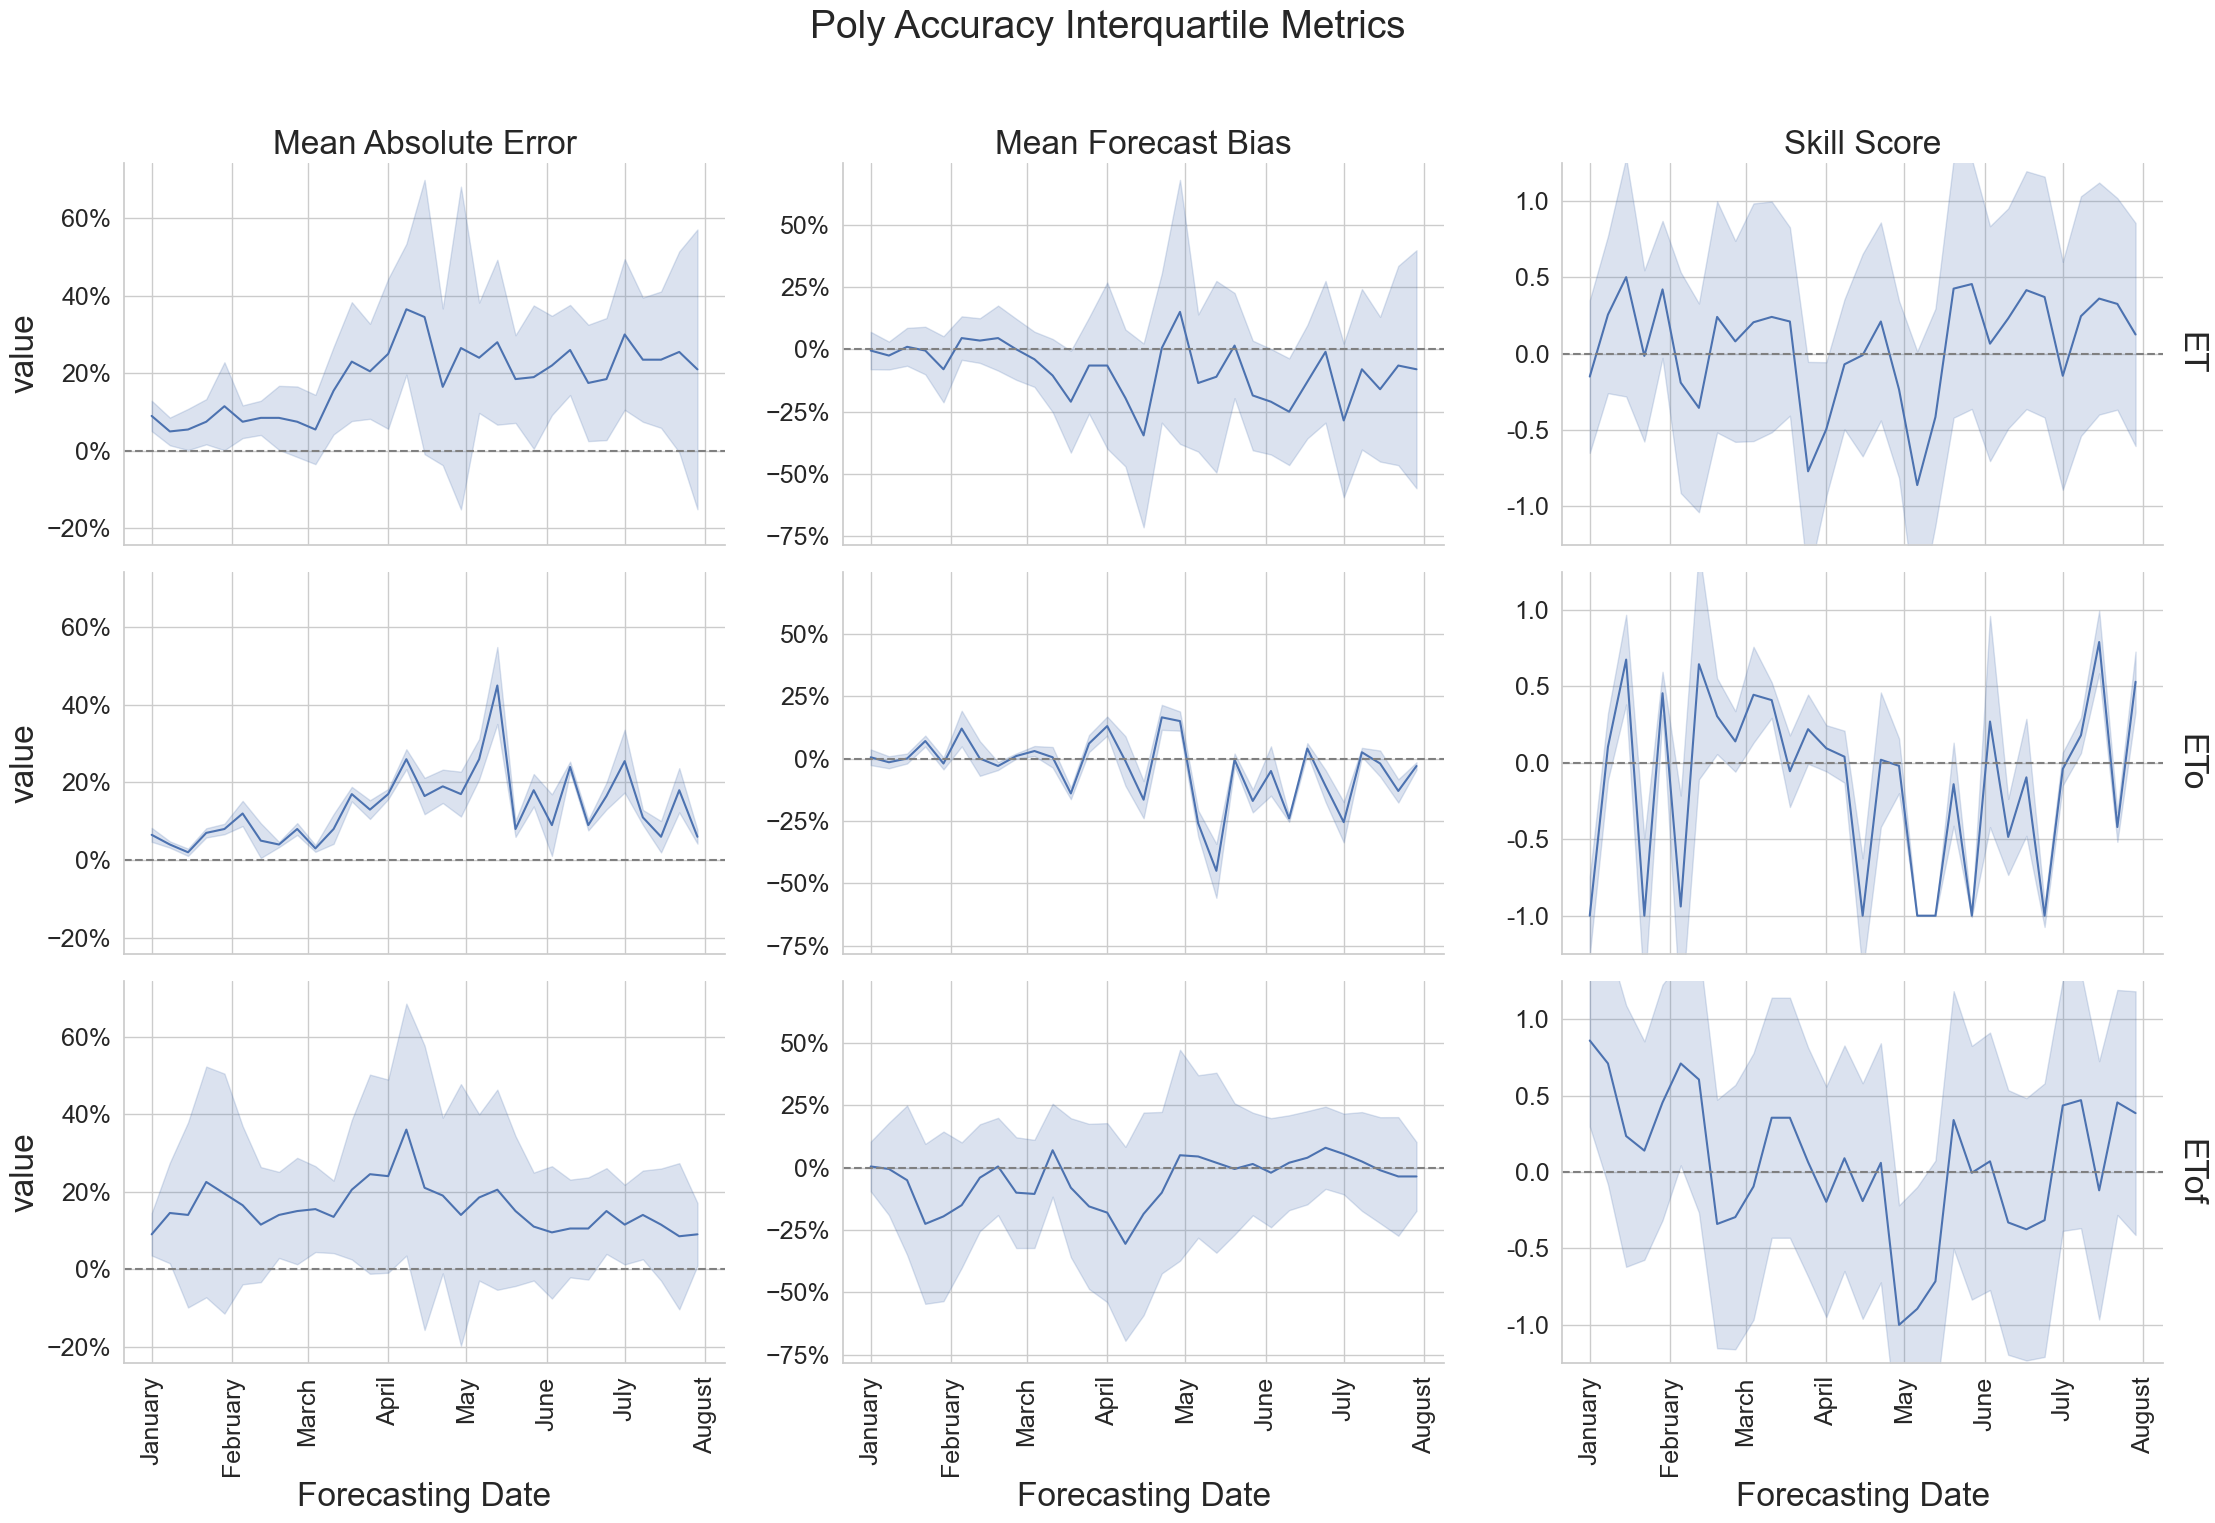

In [207]:
rel = timeseries_rel(poly_metrics_long, row='variable', col='name', y='value',
                     errorbar='sd', estimator=np.median, as_percent=True,
                     refline={'y': 0},
                     facet_kws={'sharey': 'col', 'sharex': True, 'margin_titles': True}, aspect=1.5,
                     row_order=['ET', 'ETo', 'ETof'], title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                     title="Poly Accuracy Interquartile Metrics");
rel.axes.flat[2].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[2].set(ylim=(-1.25, 1.25));
rel.axes.flat[2].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig('images/monterey/poly_field_metric_range_sd.png')

#### Point vs Polygon Comparison

A comparison is made against the same fields specified by the Polygon table.

In [208]:
point_cmp_metrics = metrics_long[metrics_long['field_id'].isin(poly_fields)]

In [209]:
point_cmp_metrics.loc[:, 'shape'] = 'point'
poly_metrics_long['shape'] = 'polygon'

shape_metrics_long = pd.concat([point_cmp_metrics, poly_metrics_long])
shape_metrics_long

C:\Users\Robin Fishman\AppData\Local\Temp\ipykernel_36312\3186246516.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  point_cmp_metrics.loc[:, 'shape'] = 'point'


forecasting_date   field_id  crop variable         stat  value  \
35         2024-01-01  CA_298674    75     ETof          mae   1.07   
60         2024-01-01  CA_299176    75     ETof          mae   0.14   
91         2024-01-01  CA_299683    75     ETof          mae   0.47   
100        2024-01-01  CA_299845    75     ETof          mae   1.30   
103        2024-01-01  CA_299867    75     ETof          mae   0.20   
...               ...        ...   ...      ...          ...    ...   
5575       2024-07-29   CA_31840    47       ET  skill_score  -1.00   
5576       2024-07-29   CA_35459    61       ET  skill_score   0.15   
5577       2024-07-29   CA_37706    47       ET  skill_score   0.98   
5578       2024-07-29   CA_39374    69       ET  skill_score  -1.00   
5579       2024-07-29   CA_42237    47       ET  skill_score  -1.00   

                     name Class_Names  ESRI_Red  ESRI_Green  ESRI_Blue  \
35    Mean Absolute Error     Almonds       0.0       168.0      132.0   
60    Mean Absolute Error     Almonds       0.0       168.0      132.0   
91    Mean Absolute Error     Almonds       0.0       168.0      132.0   
100   Mean Absolute Error     Almonds       0.0       168.0      132.0   
103   Mean Absolute Error     Almonds       0.0       168.0      132.0   
...                   ...         ...       ...         ...        ...   
5575          Skill Score         NaN       NaN         NaN        NaN   
5576          Skill Score         NaN       NaN         NaN        NaN   
5577          Skill Score         NaN       NaN         NaN        NaN   
5578          Skill Score         NaN       NaN         NaN        NaN   
5579          Skill Score         NaN       NaN         NaN        NaN   

      Erdas_Red  Erdas_Green  Erdas_Blue aligned    shape  
35          0.0       0.6471      0.5098   False    point  
60          0.0       0.6471      0.5098   False    point  
91          0.0       0.6471      0.5098   False    point  
100         0.0       0.6471      0.5098   False    point  
103         0.0       0.6471      0.5098   False    point  
...         ...          ...         ...     ...      ...  
5575        NaN          NaN         NaN     NaN  polygon  
5576        NaN          NaN         NaN     NaN  polygon  
5577        NaN          NaN         NaN     NaN  polygon  
5578        NaN          NaN         NaN     NaN  polygon  
5579        NaN          NaN         NaN     NaN  polygon  

[11160 rows x 16 columns]

##### Interquartile Comparison

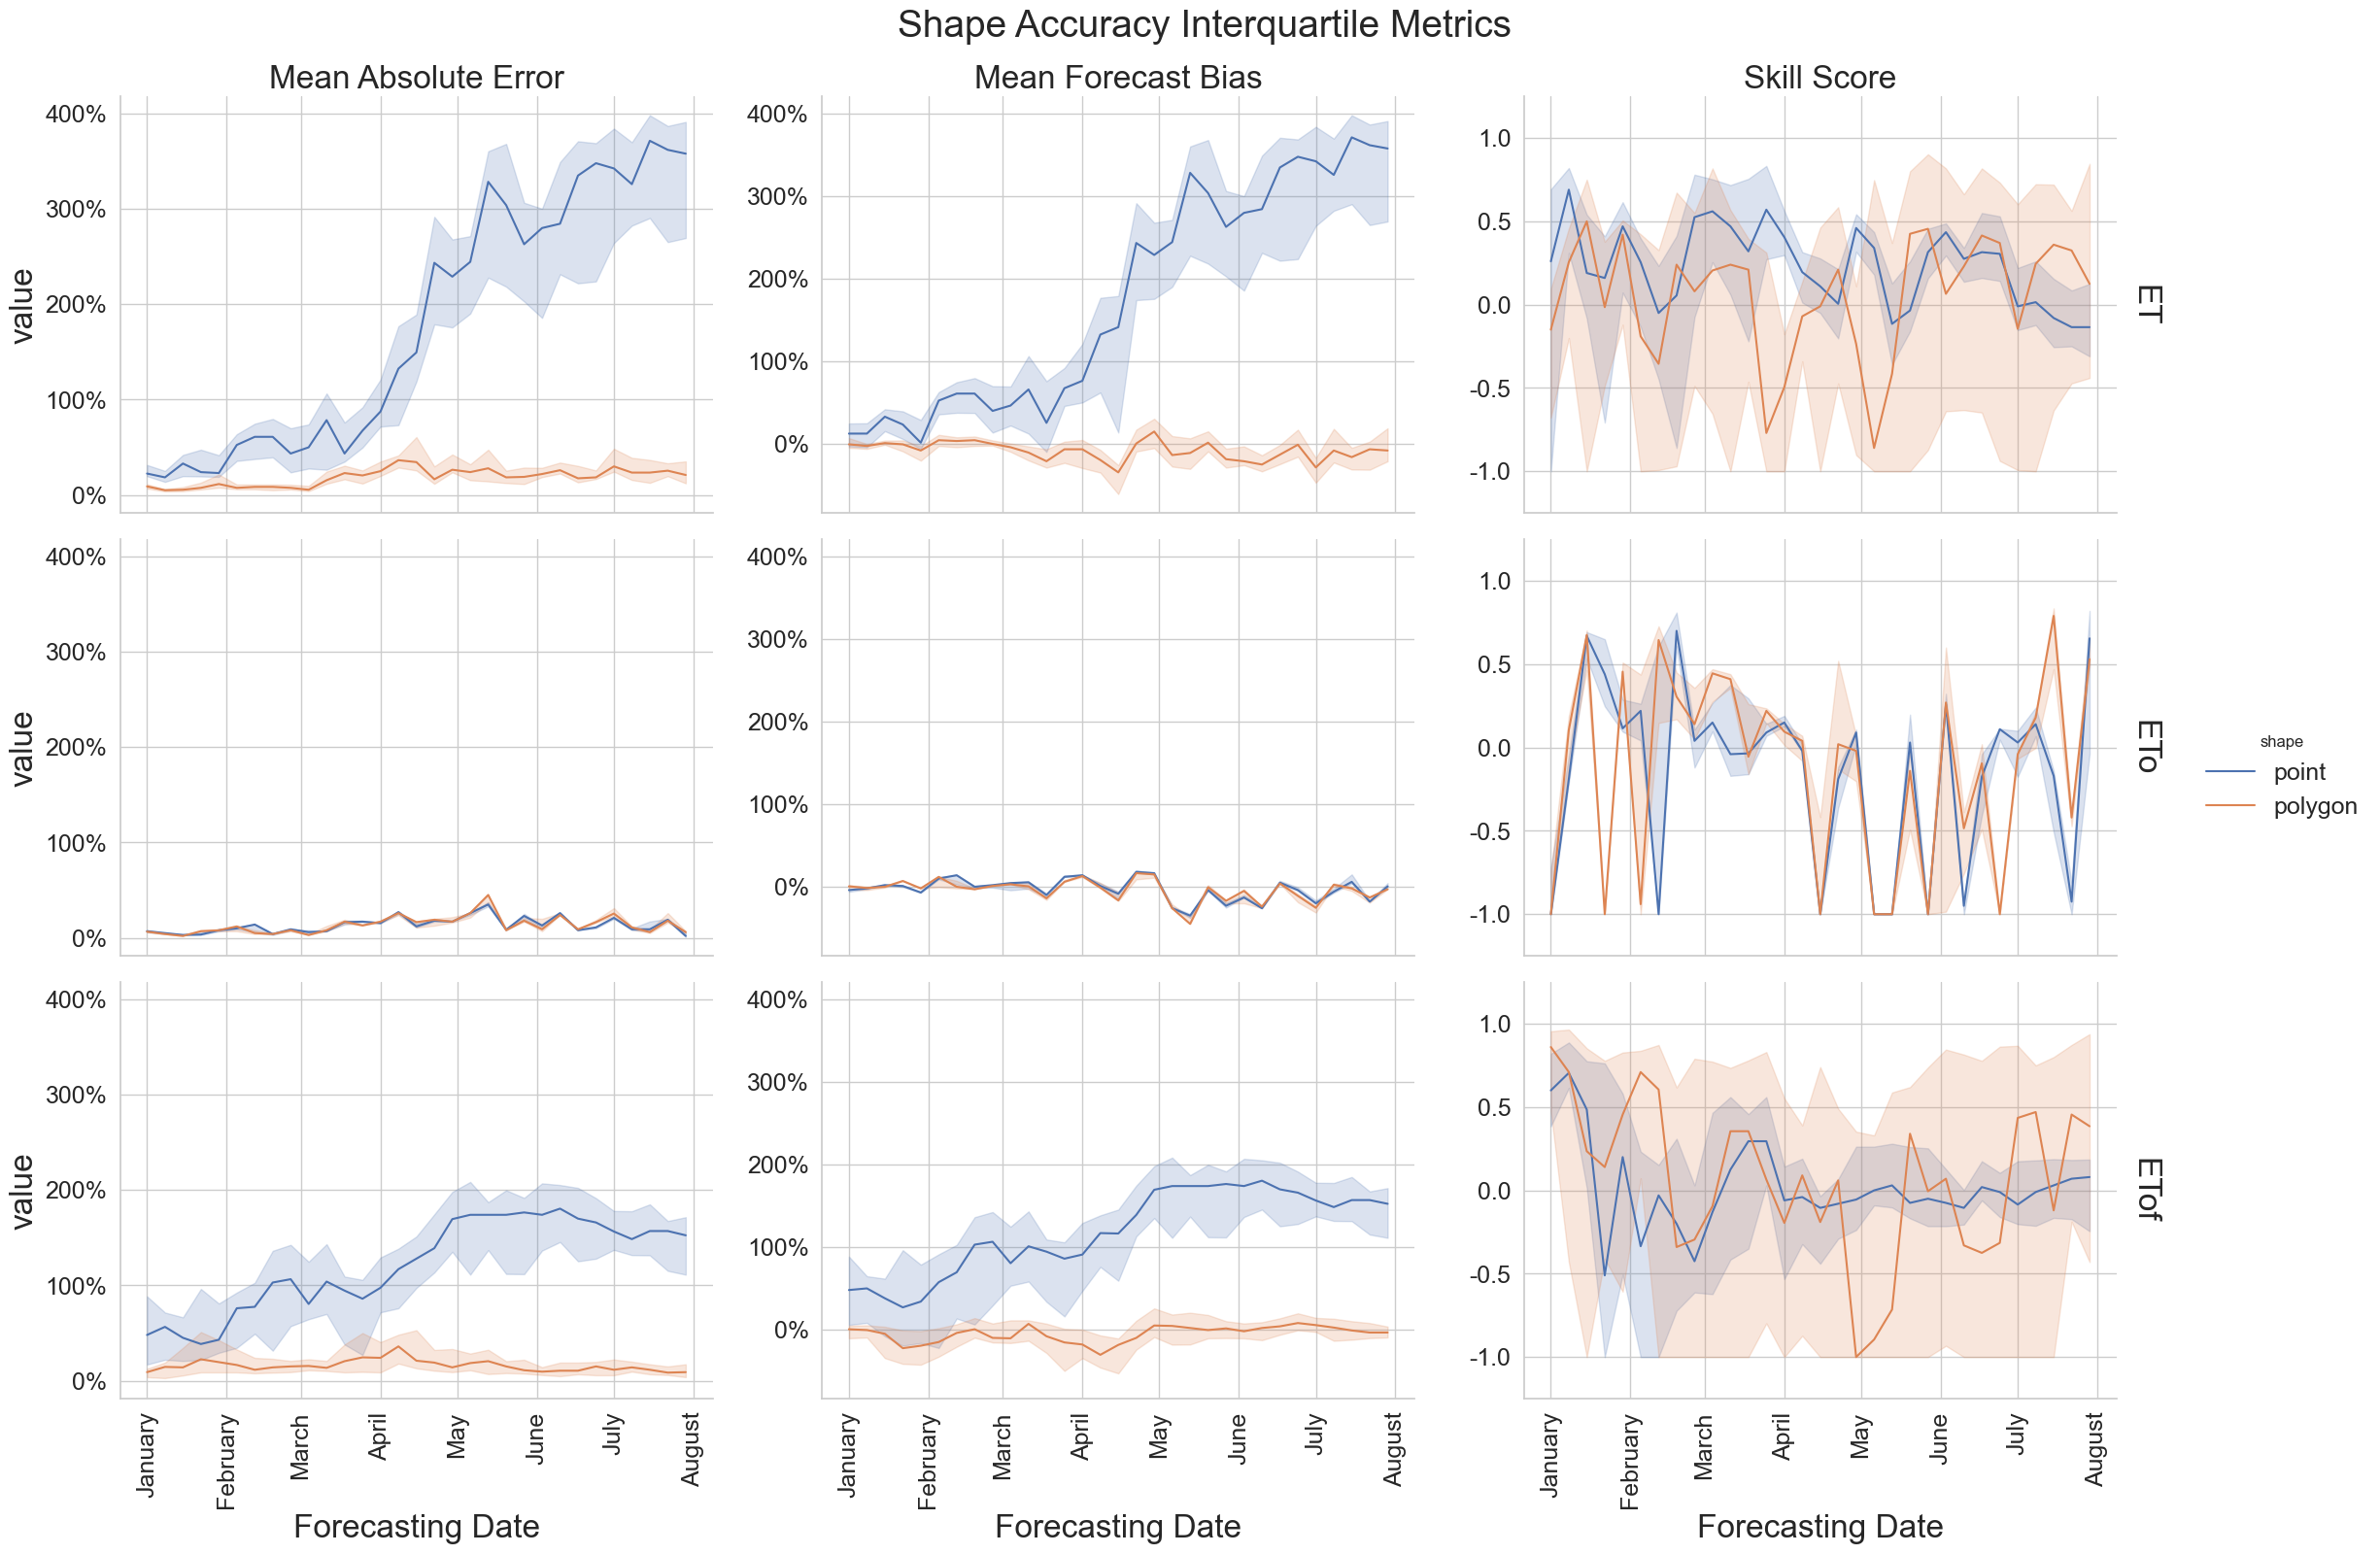

In [211]:
rel = timeseries_rel(shape_metrics_long, row='variable', col='name', y='value', hue='shape',
                     errorbar=("pi", 50), estimator=np.median, as_percent=True,
                     # refline={'y': 0},
                     facet_kws={'sharey': 'col', 'sharex': True, 'margin_titles': True}, aspect=1.5,
                     row_order=['ET', 'ETo', 'ETof'], title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                     title="Shape Accuracy Interquartile Metrics");
rel.axes.flat[2].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[2].set(ylim=(-1.25, 1.25));
rel.axes.flat[2].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig('images/kern/shape_comparison.png')